Copied from `extrapolated_masses.ipynb`

In [1]:
import numpy as np
import h5py
import pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams
import glob
import random

from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.interpolate import interp1d

from astropy.table import Table

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]
  


In [2]:
def get_median_profile(isos, pixel_scale, quantity = 'intens', rmin=0.05, rmax=4.7, nbin=150):
    """Get the median profiles."""
    sma_common = np.linspace(rmin, rmax, nbin)

    if quantity == 'intens':
        mu = np.nanmedian(np.stack([interp1d((gal['sma'] * pixel_scale) ** 0.25,
                                               np.log10(gal[quantity] / (pixel_scale ** 2)),
                                               bounds_error=False,
                                               fill_value=np.nan,
                                               kind='slinear')(sma_common)
                               for gal in isos]), axis=0)
    elif quantity == 'intens_kpc':
        mu = np.nanmedian(np.stack([interp1d((gal['sma_kpc']) ** 0.25,
                                               np.log10(gal[quantity]),
                                               bounds_error=False,
                                               fill_value=np.nan,
                                               kind='slinear')(sma_common)
                               for gal in isos]), axis=0)
    elif quantity == 'growth_ori':
        mu = np.nanmedian(np.stack([interp1d((gal['sma_kpc']) ** 0.25,
                                               np.log10(gal[quantity]),
                                               bounds_error=False,
                                               fill_value=np.nan,
                                               kind='slinear')(sma_common)
                               for gal in isos]), axis=0)
    elif quantity == 'extrapolated':
        mu = np.nanmedian(np.stack([interp1d((gal['sma_kpc']) ** 0.25,
                                               np.log10(mu_extrap(gal)),
                                               bounds_error=False,
                                               fill_value=np.nan,
                                               kind='slinear')(sma_common)
                               for gal in isos]), axis=0)
    elif quantity == 'ratio':
        mu = np.nanmedian(np.stack([interp1d((gal['sma'] * pixel_scale) ** 0.25,
                                               mu_extrap(gal)/mu_iso(gal, pixel_scale),
                                               bounds_error=False,
                                               fill_value=np.nan,
                                               kind='slinear')(sma_common)
                               for gal in isos]), axis=0)

    return sma_common, mu

def open_pkl(file_name):
    pkl = open(file_name,'rb')
    array = pickle.load(pkl)
    pkl.close()  
    return array

def hsc_quantity_in_bin(hsc_gals, mass_bins, quantity, mass_type):
    '''
    returns hsc quantity (e.g. profiles) in given mass bin
    '''
    
    #halo mass bins
    n_bins = len(mass_bins) - 1
    
    profiles_in_bins=[]
    
    if mass_type == 'halo':
        masses = hsc_gals['logmh_vir_symbol']
    elif mass_type == 'm100':
        masses = hsc_gals['logm_100']
    
    for bin in range(n_bins):
        lower = mass_bins[bin]
        upper = mass_bins[bin+1]
        
        sbps = hsc_gals[quantity][(masses>lower) & (masses<upper)]
        
        profiles_in_bins.append(sbps)
        
    return profiles_in_bins

def mu_extrap(iso, ini_r=50, final_r=100):
    power_law_iso = np.log10(powerlaw(iso['sma_kpc'],*fit_power_law_to_iso(iso, ini_r, final_r)))
    return 10**(power_law_iso+ np.log10(0.7 ** 2.0))


## TNG 

In [3]:
#open pickels
tng_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_masses_highres.pkl'
tng_isos_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_isos_merged.pkl'
tng_isos_varying_geometry_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_isos_varying_geometry_highres.pkl'


tng_masses = open_pkl(tng_masses_file)
tng_isos = open_pkl(tng_isos_file)
tng_isos_varying_geometry = open_pkl(tng_isos_varying_geometry_file)


In [45]:
#ellipticities and PA
#fill in failed galaxies
# np.where([iso is None for iso in tng_isos_varying_geometry])
tng_isos_varying_geometry[46] = Table([[100], [0], [0]], names=('sma', 'ell', 'pa'))
tng_isos_varying_geometry[215] = Table([[100], [0], [0]], names=('sma', 'ell', 'pa'))

ellipticities_100kpc = [np.interp(100, iso['sma'],iso['ell']) for iso in tng_isos_varying_geometry]
pa_100kpc = [np.interp(100, iso['sma'],iso['pa']) for iso in tng_isos_varying_geometry]

ellipticities_10kpc = [np.interp(10, iso['sma'],iso['ell']) for iso in tng_isos_varying_geometry]
pa_10kpc = [np.interp(10, iso['sma'],iso['pa']) for iso in tng_isos_varying_geometry]

ellipticity_diff = np.array(ellipticities_100kpc) - np.array(ellipticities_10kpc)
pa_diff = np.array(pa_100kpc) - np.array(pa_10kpc)

ellipticities_50kpc = [np.interp(50, iso['sma'],iso['ell']) for iso in tng_isos_varying_geometry]

## HSC 

In [4]:
################################################################################
#HSC
hsc_data_location='/Users/fardila/Documents/Github/HSC_vs_hydro/Data/HSC/'

# Universal RSMA array
hsc_sma = np.arange(0.4, 4.2, 0.01)

#masses
hsc_file = hsc_data_location+'s16a_mass_good_mhalo_frac4_180503.fits'
hsc_table = Table.read(hsc_file)


## create HSC-like sample of TNG galaxies 

for every HSC galaxy, select a TNG galaxy with similar M10 and M100

do extrapolation tests with these

In [43]:
np.random.seed(200)
rows_numbers_to_keep = np.random.choice(len(hsc_table), 50, replace=False)
reduced_hsc_table = hsc_table[rows_numbers_to_keep]
rows_numbers_to_keep

array([12569,  5729,  6663, 14695,  1420, 11137,  5931, 14376,  1712,
       11337, 13132,  2538, 21475, 12049,  7689,  8258, 11363,  4925,
       10100, 19605, 24685, 18451, 18114,   593,  2749,  1140, 11482,
       14721, 25319, 23759,  5642, 23198, 22106,  8848, 13759, 10008,
       14974,  3967,  9481, 13668,  7829, 10081, 15380, 17683, 10355,
       22830,  3884, 12730, 23371,  8274])

In [44]:
similar_ids=[]
for hsc_gal in reduced_hsc_table:
    
    distances = np.sqrt((tng_masses['m_1d_100']-hsc_gal['logm_100'])**2 + (tng_masses['m_1d_10']-hsc_gal['logm_10'])**2)
    sorted_tng_indices = np.argsort(distances)
    
    i=0
    closest_tng_index = sorted_tng_indices[i]
    
    #if already in list, loop until one isn't
    while closest_tng_index in similar_ids:
        i+=1
        closest_tng_index = sorted_tng_indices[i]
        
    similar_ids.append(closest_tng_index)
    print distances[closest_tng_index]

similar_tng_isos = np.array(tng_isos)[similar_ids]
similar_tng_masses = tng_masses[similar_ids]



0.015099325938162635
0.012811565368639064
0.009813189475368342
0.02029458278139614
0.010182048444428682
0.015298211054785002
0.03883620326604923
0.020396216078421042
0.04007313352707807
0.0230295522525054
0.07731309455616255
0.029746748480450683
0.01673110258303917
0.040348597138922665
0.02174569675702933
0.04541374481151031
0.012003303220200583
0.007130655293485372
0.014344583701340051
0.05731133255772724
0.010657503157029347
0.027677386721114926
0.008686587310242763
0.04620423573679942
0.06400769466557228
0.023252304449757757
0.007686524499873757
0.025237207027070184
0.09611214840367169
0.07269109494754013
0.0079242652795502
0.009028771553199349
0.02517326409561375
0.04446352676719269
0.03046216545259593
0.01551264074711771
0.0483491249678109
0.06629695757048956
0.044894385398216066
0.034588185725929255
0.14121312844776093
0.002271595677417631
0.03675372612976478
0.016778150680928708
0.04216476121374443
0.03852011370438505
0.061646257226050494
0.021817329254937352
0.00285988372314287

In [12]:
print len(similar_ids), len(np.unique(similar_ids))

50 50


/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


50


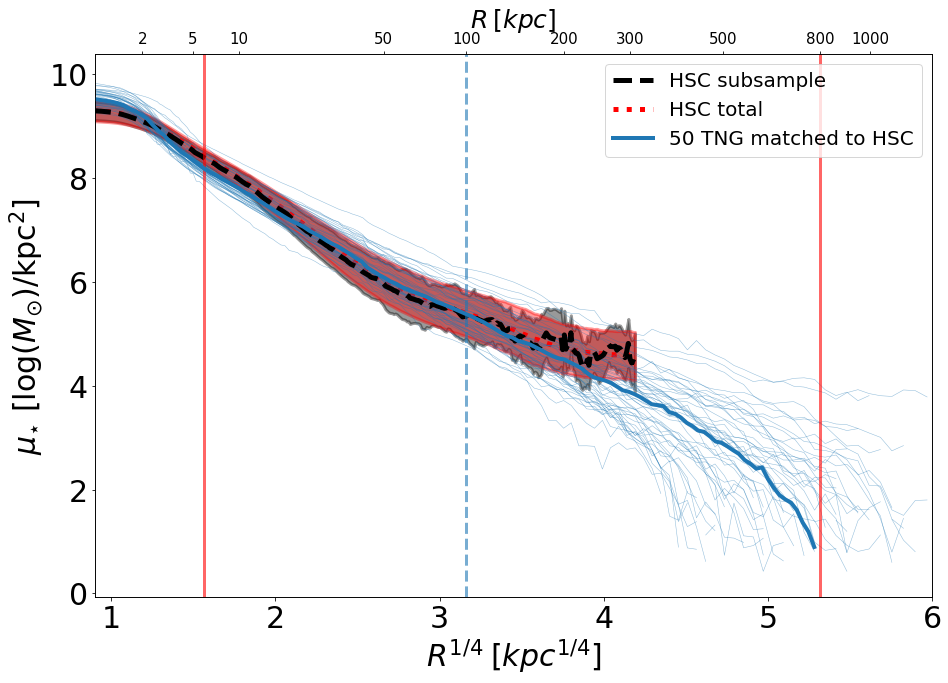

In [13]:
ngals1=0

#plot
fig =plt.figure(figsize=(15, 10))
ax1 = plt.subplot()


######################################################################################################################
# plot
######################################################################################################################
#hsc
hsc_median1 = np.nanmedian(reduced_hsc_table['sbp'], axis=0)
hsc_median2 = np.nanmedian(hsc_table['sbp'], axis=0)
#stds (masked_invalid to exclude infinities)
hsc_std1 = np.nanstd(np.ma.masked_invalid(reduced_hsc_table['sbp']),axis=0)
hsc_std2 = np.nanstd(np.ma.masked_invalid(hsc_table['sbp']),axis=0)

ax1.plot(hsc_sma, hsc_median1, linestyle='--', linewidth=5.0, c='k', alpha=1, zorder=2, label='HSC subsample')
ax1.plot(hsc_sma, hsc_median2, linestyle=':', linewidth=5.0, c='r', alpha=1, zorder=1, label='HSC total')

ax1.fill_between(hsc_sma, hsc_median1+hsc_std1, hsc_median1-hsc_std1, alpha=0.4, color='k', zorder=1, linewidth=3)
ax1.fill_between(hsc_sma, hsc_median2+hsc_std2, hsc_median2-hsc_std2, alpha=0.4, color='r', zorder=1, linewidth=3)


#TNG

for iso in similar_tng_isos:   

        ngals1+=1

        #tng_isos1.append(iso)

        ax1.plot((iso['sma_kpc'] ) ** 0.25,
             np.log10(iso['intens_kpc'])+ np.log10(0.7 ** 2.0) , linewidth=0.5, c=u'#1f77b4', alpha=0.5, 
                 label='_nolegend_', zorder=1)
                 #label='tng Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))


# ## median profiles for tng
median_sma1, median_mu1 = get_median_profile(similar_tng_isos, quantity='intens_kpc', pixel_scale = 1,
                                             rmax=800.**0.25)

ax1.plot(median_sma1, median_mu1+ np.log10(0.7 ** 2.0), linewidth=4.0, c=u'#1f77b4', alpha=1, label='50 TNG matched to HSC', zorder=8)


print ngals1


######################################################################################################################
# plot details
######################################################################################################################
# # X-Y limits
ax1.set_xlim(0.9, 6)
#ax1.set_ylim(-2, 10)

# Labels
ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
               size=60)
ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
#ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

ax1.legend(fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25, 500**0.25, 800**0.25, 1000**0.25])
ax1_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300, 500, 800, 1000])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=30)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axvline(800.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')

######################################################################################################################
#adjustments to ticks and space between subplots

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/surface_brightness_tng.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')

plt.show()

In [22]:
similar_tng_masses

m_1d_10,m_1d_30,m_1d_100,m_1d_500,m_1d_800,m_2d_10,m_2d_30,m_2d_100,m_2d_500,m_2d_800,extrapolated_m_300,extrapolated_m_500,extrapolated_m_800,m_cat,m_post,m_post_icl
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
11.118321079780015,11.287489322760603,11.369117345614516,11.384982162544512,11.384982162544512,11.163487310255505,11.325669323496344,11.405080470773633,11.42466374237932,11.42466374237932,11.405888650488622,11.415481222036611,11.421830892007522,11.446577434654298,11.424663744174474,11.424724101215542
11.086901360189735,11.230323551020529,11.29757657971815,11.306464193086342,11.306464193086342,11.122053015359961,11.262155899975157,11.32805457537951,11.336320536084733,11.336320536084733,11.31514149736916,11.318084980177558,11.319597532664416,11.340397044874313,11.336320535852748,11.33632606595042
11.143220573682918,11.40029217906579,11.528816735259086,11.558618733011183,11.558618733011183,11.165894192096811,11.40653456144144,11.518478813641288,11.537112110100766,11.537112110100766,11.581947496282542,11.593432653305516,11.600322050143525,11.543368044971611,11.5371121109051,11.537118525516776
11.128926628557126,11.314641437782482,11.403300283048523,11.419860273190046,11.419860273190046,11.147740805807262,11.33787908292166,11.431743867063012,11.448827931133543,11.448827931133543,11.42898709962885,11.433556387681273,11.435991281523373,11.455801365940301,11.44882792980078,11.448848428962943
11.167661039800233,11.315025994464197,11.41969274919454,11.49339965240941,11.49339965240941,11.072327390323666,11.212040056597383,11.336420724204778,11.452726621231038,11.453215523668609,11.572607213455294,11.628100101153303,11.673241139470546,11.498809116908497,11.45321552231051,11.453235593511877
11.042899568306545,11.231475653017212,11.295982785364078,11.338860607393032,11.338860607393032,11.079029137789517,11.241901776501965,11.295076374223745,11.323053263112486,11.323053263112486,11.350272277181652,11.371660957037681,11.389588498623215,11.34654113822936,11.323053262889447,11.323193087556778
11.311151406117824,11.510309280842948,11.652965193084166,11.711071893426727,11.711071893426727,11.338018480421576,11.531365177961668,11.670714623959237,11.725434800175792,11.725434800175792,11.78178692829761,11.834666949839548,11.880332753085138,11.84346327419548,11.725434801101303,11.725900136749436
11.33978343626982,11.470204449155872,11.559899852956374,11.57534295563788,11.57534295563788,11.380551200538576,11.506460268168373,11.596145032676773,11.612832047006444,11.612832047006444,11.599176926725189,11.608869774926601,11.615094917040368,11.629157418881787,11.612832046039022,11.612834493533475
11.046697815009415,11.180933715967154,11.231088885226548,11.236983533619902,11.236983533619902,11.093146956856875,11.221255697829717,11.270286093058706,11.27655874594257,11.27655874594257,11.246887437092127,11.250139152545485,11.252009848197163,11.279291886979316,11.276558748230292,11.276558748230292


<function matplotlib.pyplot.show>

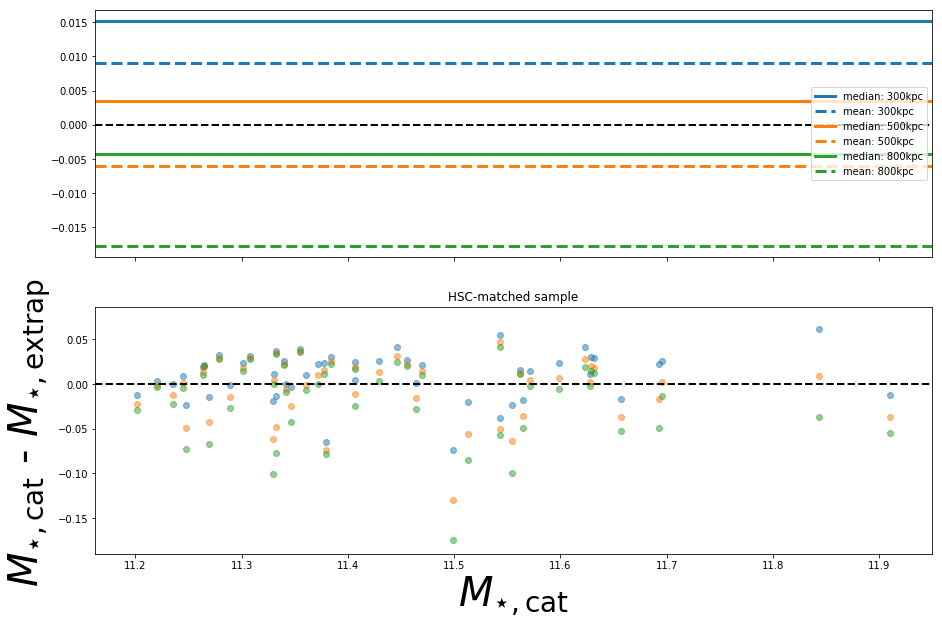

In [23]:
fig, axes = plt.subplots(2,1, figsize=(15, 10), sharex=True)
axes[1].scatter(similar_tng_masses['m_cat'], similar_tng_masses['m_cat']-similar_tng_masses['extrapolated_m_300'], alpha=0.5)
axes[1].scatter(similar_tng_masses['m_cat'], similar_tng_masses['m_cat']-similar_tng_masses['extrapolated_m_500'], alpha=0.5)
axes[1].scatter(similar_tng_masses['m_cat'], similar_tng_masses['m_cat']-similar_tng_masses['extrapolated_m_800'], alpha=0.5)

axes[0].axhline(np.median(similar_tng_masses['m_cat']-similar_tng_masses['extrapolated_m_300']),
            color='C0', linewidth=3, label = 'median: 300kpc')
axes[0].axhline(np.mean(similar_tng_masses['m_cat']-similar_tng_masses['extrapolated_m_300']),
            linestyle='--', linewidth=3, color='C0', label = 'mean: 300kpc')

axes[0].axhline(np.median(similar_tng_masses['m_cat']-similar_tng_masses['extrapolated_m_500']),
            color='C1', linewidth=3, label = 'median: 500kpc')
axes[0].axhline(np.mean(similar_tng_masses['m_cat']-similar_tng_masses['extrapolated_m_500']),
            linestyle='--', linewidth=3, color='C1', label = 'mean: 500kpc')

axes[0].axhline(np.median(similar_tng_masses['m_cat']-similar_tng_masses['extrapolated_m_800']),
            color='C2', linewidth=3, label = 'median: 800kpc')
axes[0].axhline(np.mean(similar_tng_masses['m_cat']-similar_tng_masses['extrapolated_m_800']),
            linestyle='--', linewidth=3, color='C2', label = 'mean: 800kpc')


axes[1].axhline(0,c="k",linewidth=2,linestyle='--')
axes[0].axhline(0,c="k",linewidth=2,linestyle='--')
plt.ylabel(r'$M_{\star, \mathrm{cat}}$ - $M_{\star, \mathrm{{extrap}}}$ ', fontsize=40)
plt.xlabel('$M_{\star, \mathrm{cat}}$', fontsize=40)
plt.title('HSC-matched sample')
axes[0].legend(loc='right')
# axes[1].set_ylim([-0.05,0.05])
plt.show

## All TNG galaxies 

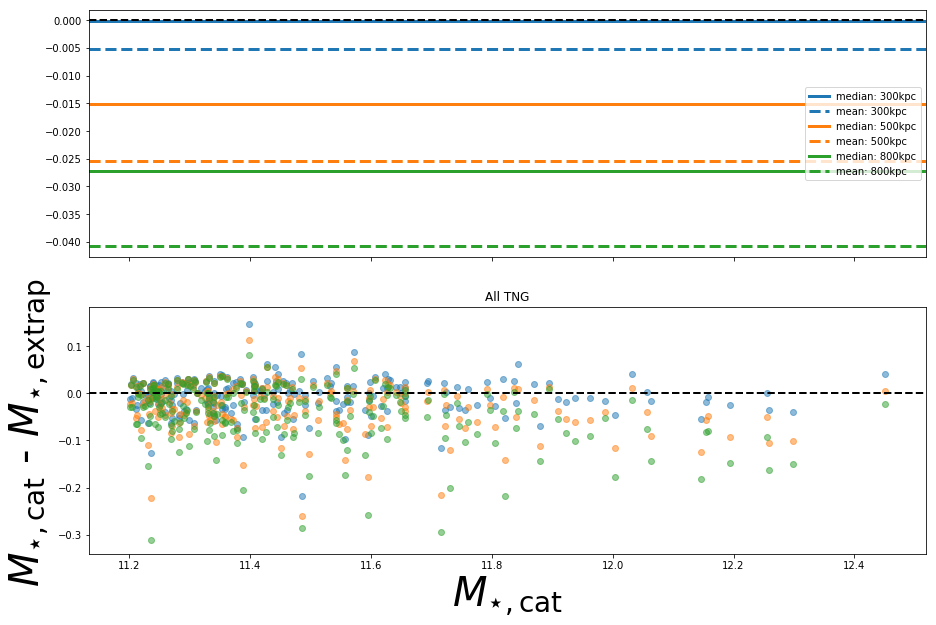

In [24]:
fig, axes = plt.subplots(2,1, figsize=(15, 10), sharex=True)
axes[1].scatter(tng_masses['m_cat'], tng_masses['m_cat']-tng_masses['extrapolated_m_300'], alpha=0.5)
axes[1].scatter(tng_masses['m_cat'], tng_masses['m_cat']-tng_masses['extrapolated_m_500'], alpha=0.5)
axes[1].scatter(tng_masses['m_cat'], tng_masses['m_cat']-tng_masses['extrapolated_m_800'], alpha=0.5)

axes[0].axhline(np.median(tng_masses['m_cat']-tng_masses['extrapolated_m_300']),
            color='C0', linewidth=3, label = 'median: 300kpc')
axes[0].axhline(np.mean(tng_masses['m_cat']-tng_masses['extrapolated_m_300']),
            linestyle='--', linewidth=3, color='C0', label = 'mean: 300kpc')

axes[0].axhline(np.median(tng_masses['m_cat']-tng_masses['extrapolated_m_500']),
            color='C1', linewidth=3, label = 'median: 500kpc')
axes[0].axhline(np.mean(tng_masses['m_cat']-tng_masses['extrapolated_m_500']),
            linestyle='--', linewidth=3, color='C1', label = 'mean: 500kpc')

axes[0].axhline(np.median(tng_masses['m_cat']-tng_masses['extrapolated_m_800']),
            color='C2', linewidth=3, label = 'median: 800kpc')
axes[0].axhline(np.mean(tng_masses['m_cat']-tng_masses['extrapolated_m_800']),
            linestyle='--', linewidth=3, color='C2', label = 'mean: 800kpc')


axes[1].axhline(0,c="k",linewidth=2,linestyle='--')
axes[0].axhline(0,c="k",linewidth=2,linestyle='--')
plt.ylabel(r'$M_{\star, \mathrm{cat}}$ - $M_{\star, \mathrm{{extrap}}}$ ', fontsize=40)
plt.xlabel('$M_{\star, \mathrm{cat}}$', fontsize=40)
plt.title('All TNG') #remove
axes[0].legend(loc='right')
# axes[1].set_ylim([-0.05,0.05])
plt.show()

# TODO: make legend labels more clear

## plot profiles and extrapolations


/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


50


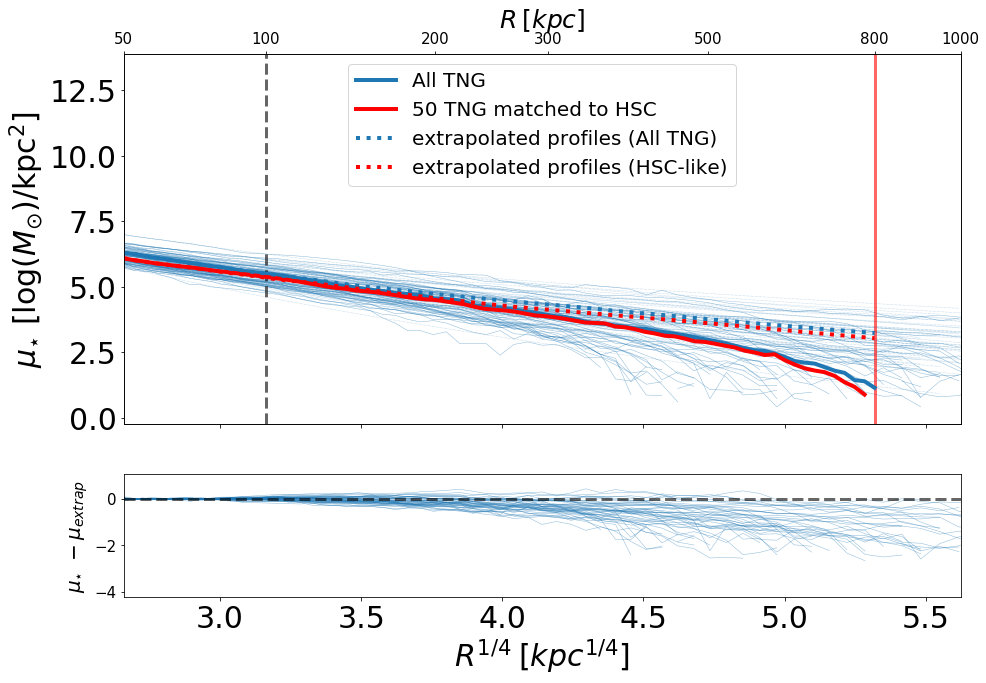

In [68]:
ngals1=0

#plot
f, (ax1, ax2) = plt.subplots(2,1, figsize=(15, 10), sharex=True, gridspec_kw = {'height_ratios':[3, 1]})


######################################################################################################################
# plot
######################################################################################################################

#TNG

for iso in similar_tng_isos[:]:   

        ngals1+=1

        ax1.plot((iso['sma_kpc'] ) ** 0.25,
             np.log10(iso['intens_kpc'])+ np.log10(0.7 ** 2.0) , linewidth=0.5, c=u'#1f77b4', alpha=0.5, 
                 label='_nolegend_', zorder=1)
        

        ax1.plot((iso['sma_kpc'] ) ** 0.25,
                 np.log10(mu_extrap(iso)), 
                 linewidth=0.5, c=u'#1f77b4', alpha=0.5, linestyle=':', 
                 label='_nolegend_', zorder=1)
        
        #plot difference
        ax2.plot((iso['sma_kpc'] ) ** 0.25,
                 np.log10(iso['intens_kpc'])+ np.log10(0.7 ** 2.0) - np.log10(mu_extrap(iso)), 
                 linewidth=0.5, c=u'#1f77b4', alpha=0.5, 
                 label='_nolegend_', zorder=1)


# ## median profiles for tng
median_sma1, median_mu1 = get_median_profile(similar_tng_isos, quantity='intens_kpc', pixel_scale = 1,
                                             rmax=800.**0.25)
median_sma_all, median_mu_all = get_median_profile(tng_isos, quantity='intens_kpc', pixel_scale = 1,
                                             rmax=800.**0.25)

median_sma_extrap, median_mu_extrap = get_median_profile(similar_tng_isos, quantity='extrapolated', pixel_scale = 1,
                                             rmax=800.**0.25)
median_sma_extrap_all, median_mu_extrap_all = get_median_profile(tng_isos, quantity='extrapolated', pixel_scale = 1,
                                             rmax=800.**0.25)

ax1.plot(median_sma_all, median_mu_all+ np.log10(0.7 ** 2.0), linewidth=4.0, c=u'#1f77b4', alpha=1, label='All TNG',
         zorder=8)
ax1.plot(median_sma1, median_mu1+ np.log10(0.7 ** 2.0), linewidth=4.0, c='r', alpha=1, label='50 TNG matched to HSC',
         zorder=8)

ax1.plot(median_sma_extrap_all, median_mu_extrap_all, linewidth=4.0, c=u'#1f77b4', alpha=1, label='extrapolated profiles (All TNG)',
         zorder=8, linestyle=':')
ax1.plot(median_sma_extrap, median_mu_extrap, linewidth=4.0, c='r', alpha=1, label='extrapolated profiles (HSC-like)',
         zorder=8, linestyle=':')


print ngals1


######################################################################################################################
# plot details
######################################################################################################################
# # X-Y limits
ax1.set_xlim(0.9, 6)
#ax1.set_ylim(-2, 10)

# Labels
# ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
#                size=60)
# ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
#                size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)
ax2.tick_params(axis='both', which='major', labelsize=30)
#text label
#ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

ax1.legend(fontsize=20)

#add twin x axis in kpc
ax1.set_xlim([50**0.25,1000**0.25])
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([50**0.25, 100**0.25, 200**0.25, 300**0.25, 500**0.25, 800**0.25, 1000**0.25])
ax1_twin.xaxis.set_ticklabels([50, 100, 200, 300, 500, 800, 1000])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='y', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax2.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax2.set_ylabel(r'$\mu_{\star}\ - \mu_{extrap}$ ', fontsize=20)
ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=30)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6, c='k')
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axvline(800.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')

ax2.axhline(0, linestyle='--', linewidth=3.0, alpha=0.6, c='k')


######################################################################################################################
#adjustments to ticks and space between subplots

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/surface_brightness_tng.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')

plt.show()

/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/Users/fardila/anaconda2/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


50


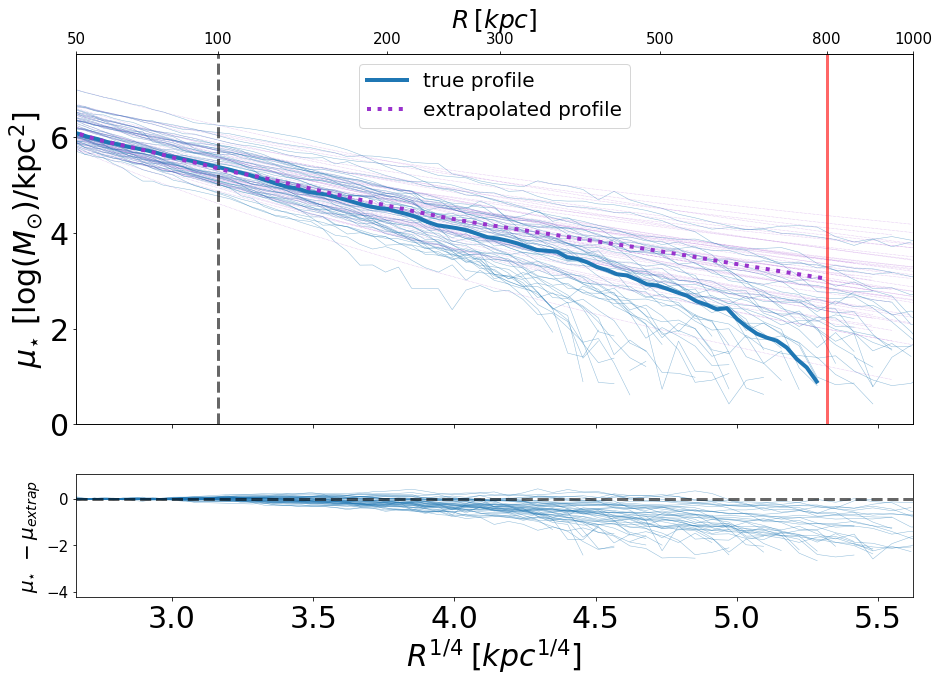

In [81]:
ngals1=0

#plot
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15, 10), sharex=True, gridspec_kw = {'height_ratios':[3, 1]})


######################################################################################################################
# plot
######################################################################################################################

#TNG

for iso in similar_tng_isos[:]:   

        ngals1+=1

        ax1.plot((iso['sma_kpc'] ) ** 0.25,
             np.log10(iso['intens_kpc'])+ np.log10(0.7 ** 2.0) , linewidth=0.5, c=u'#1f77b4', alpha=0.5, 
                 label='_nolegend_', zorder=1)
        

        ax1.plot((iso['sma_kpc'] ) ** 0.25,
                 np.log10(mu_extrap(iso)), 
                 linewidth=0.5, c='darkorchid', alpha=0.5, linestyle=':', 
                 label='_nolegend_', zorder=1)
        
        #plot difference
        ax2.plot((iso['sma_kpc'] ) ** 0.25,
                 np.log10(iso['intens_kpc'])+ np.log10(0.7 ** 2.0) - np.log10(mu_extrap(iso)), 
                 linewidth=0.5, c=u'#1f77b4', alpha=0.5, 
                 label='_nolegend_', zorder=1)


# ## median profiles for tng
median_sma1, median_mu1 = get_median_profile(similar_tng_isos, quantity='intens_kpc', pixel_scale = 1,
                                             rmax=800.**0.25)
# median_sma_all, median_mu_all = get_median_profile(tng_isos, quantity='intens_kpc', pixel_scale = 1,
#                                              rmax=800.**0.25)

median_sma_extrap, median_mu_extrap = get_median_profile(similar_tng_isos, quantity='extrapolated', pixel_scale = 1,
                                             rmax=800.**0.25)
# median_sma_extrap_all, median_mu_extrap_all = get_median_profile(tng_isos, quantity='extrapolated', pixel_scale = 1,
#                                              rmax=800.**0.25)

# ax1.plot(median_sma_all, median_mu_all+ np.log10(0.7 ** 2.0), linewidth=4.0, c=u'#1f77b4', alpha=1, label='All TNG',
#          zorder=8)
ax1.plot(median_sma1, median_mu1+ np.log10(0.7 ** 2.0), linewidth=4.0, c=u'#1f77b4', alpha=1, label='true profile',
         zorder=8)

# ax1.plot(median_sma_extrap_all, median_mu_extrap_all, linewidth=4.0, c=u'#1f77b4', alpha=1, label='extrapolated profiles (All TNG)',
#          zorder=8, linestyle=':')
ax1.plot(median_sma_extrap, median_mu_extrap, linewidth=4.0, c='darkorchid', alpha=1, label='extrapolated profile',
         zorder=8, linestyle=':')


print ngals1


######################################################################################################################
# plot details
######################################################################################################################
# # X-Y limits
ax1.set_xlim([50**0.25,1000**0.25])
ax1.set_ylim(0, 7.75)

# Labels
# ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
#                size=60)
# ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
#                size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)
ax2.tick_params(axis='both', which='major', labelsize=30)
#text label
#ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

ax1.legend(fontsize=20)

#add twin x axis in kpc

x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([50**0.25, 100**0.25, 200**0.25, 300**0.25, 500**0.25, 800**0.25, 1000**0.25])
ax1_twin.xaxis.set_ticklabels([50, 100, 200, 300, 500, 800, 1000])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='y', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax2.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax2.set_ylabel(r'$\mu_{\star}\ - \mu_{extrap}$ ', fontsize=20)
ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=30)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6, c='k')
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axvline(800.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')

ax2.axhline(0, linestyle='--', linewidth=3.0, alpha=0.6, c='k')


######################################################################################################################
#adjustments to ticks and space between subplots

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/extrapolation.pdf',
            dpi=100, format='pdf', bbox_inches='tight')

plt.show()

## plot Mextrap/Mcat vs. M100 for different alpha 

In [60]:
similar_tng_masses

m_1d_10,m_1d_30,m_1d_100,m_1d_500,m_1d_800,m_2d_10,m_2d_30,m_2d_100,m_2d_500,m_2d_800,extrapolated_m_300,extrapolated_m_500,extrapolated_m_800,m_cat,m_post,m_post_icl
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
11.044520982452832,11.193261326686454,11.263194640616877,11.320036271895798,11.320036271895798,11.048974254079118,11.187979807817262,11.265193524749213,11.294337604155155,11.294337604155155,11.349046878629482,11.391123222429545,11.430945428723419,11.329843459510885,11.294337605033546,11.294810169532525
11.068507616330182,11.203295419374488,11.27771660951827,11.29293665671519,11.29293665671519,11.114984990397351,11.244766562185676,11.314196237245591,11.32710998891505,11.32710998891505,11.295476909342208,11.298116765701375,11.299387395279732,11.332332949625142,11.32710998838882,11.327117779952975
11.056144972913774,11.19602429220689,11.261499023306012,11.273851109948861,11.273851109948861,11.086257682741861,11.21826068985495,11.284610960722974,11.296808757994807,11.296808757994807,11.277141435476105,11.279519034815985,11.280676303208272,11.308087348712656,11.29680875777525,11.297043487661515
11.18215279303629,11.37205787306812,11.453570515428245,11.472792362184592,11.472792362184592,11.209493884727484,11.398349452945514,11.480831163056479,11.500663864315275,11.500663864315275,11.487654424337046,11.496190673212466,11.501708519194459,11.542711575106628,11.500663864454367,11.500665371061306
11.27150035456996,11.430906772952953,11.534426494059868,11.56105341189169,11.56105341189169,11.301058848536028,11.458045174012861,11.562503996949836,11.58960117529482,11.58960117529482,11.582332647930182,11.595195873506984,11.603879963705296,11.623055397175804,11.589601173549662,11.589601173549662
11.176665221239944,11.21963824792365,11.25681716772968,11.270360908554284,11.270360908554284,11.19549606877112,11.233518804837255,11.271818563808349,11.284615234730628,11.284615234730628,11.290750650139312,11.304398180494264,11.315944904857336,11.289252075186399,11.284615233452016,11.284641913289686
11.444742801255723,11.715099214609545,11.834328356168488,11.864975667626325,11.864975667626325,11.467698929077336,11.73524626964396,11.850723126612186,11.877327670837703,11.877327670837703,11.872565224925472,11.880170435421602,11.884502626584307,11.894307000635841,11.877327670270066,11.87733300798555
11.206349244974076,11.329566691154142,11.411722257243625,11.440357468470843,11.440357468470843,11.232690734323613,11.348820867478521,11.427450362923627,11.451766834587845,11.451766834587845,11.463275318827524,11.47981201862892,11.492155618107217,11.463920415262383,11.451766833623745,11.45180885579798
11.253480061436454,11.422190448292591,11.552969474106863,11.584727165875512,11.584727165875512,11.278631902875254,11.449310951312217,11.582935322279761,11.608476163926786,11.608476163926786,11.60231139936097,11.613089548850812,11.619582753492608,11.631210533230256,11.608476165432617,11.608477560462173


## get power law slopes 

In [36]:
def powerlaw(x, m, c):
    return x**m * c

def ellipse_perimeter(a,b):
    '''perimeter of an ellipse from Ramanujan's approximation'''
    perimeter = np.pi * ( 3*(a+b) - np.sqrt( (3*a + b) * (a + 3*b) ) )
    return perimeter

def mass_per_r(r, power_law_params, e):
    q=1-e
    b=r*q
    return powerlaw(r,*power_law_params)*ellipse_perimeter(r,b)

def fit_power_law_to_iso(iso, ini_r, final_r):

    x=iso['sma_kpc'][(iso['sma_kpc']>ini_r) & (iso['sma_kpc']<final_r)]
    y=iso['intens_kpc'][(iso['sma_kpc']>ini_r) & (iso['sma_kpc']<final_r)]

    p_fit_power, _ = curve_fit(powerlaw, x, y, p0=[-2,10**10])

    return p_fit_power

def extrapolated_1D_mass(iso, max_r):

    #fit power law between 50 and 100kpc
    p_fit_power = fit_power_law_to_iso(iso, 50, 100)
    #print p_fit_power

    #integrate between 100 and max_r to get mass
    e = iso['ell'][1]
    mass_beyond100, mass_err =quad(mass_per_r, 100, max_r, args=tuple([p_fit_power, e]))

    #add to galSBP mass to get total mass
    mass_100 = 10**(oneD_mass(iso, 100))
    power_law_fit_mass = np.log10(mass_100+mass_beyond100)

    return power_law_fit_mass

In [45]:
power_law_slopes = [fit_power_law_to_iso(iso, 50, 100)[0] for iso in similar_tng_isos]

power_law_intercepts = [np.log10(fit_power_law_to_iso(iso, 50, 100)[1]) for iso in similar_tng_isos]


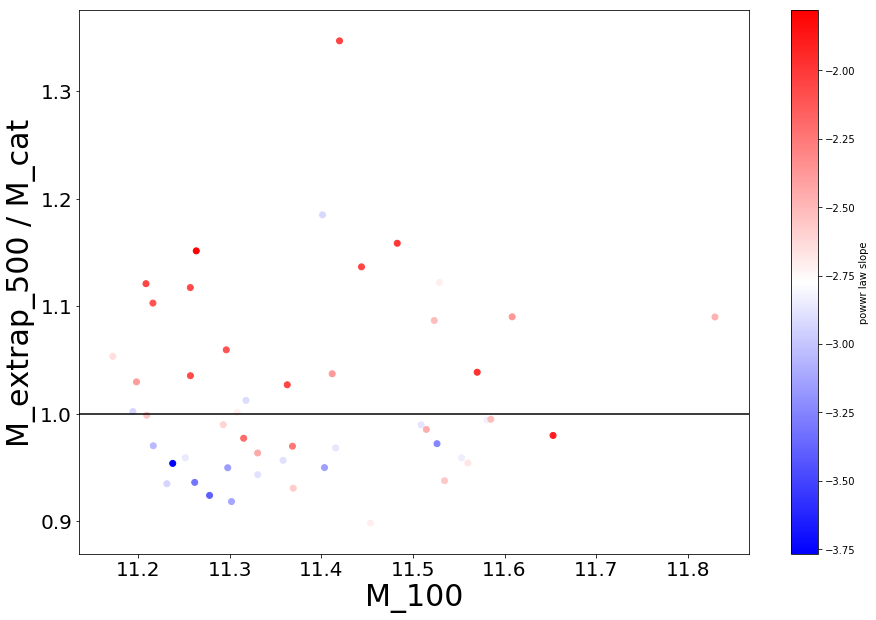

In [28]:
fig, ax = plt.subplots(1,1, figsize=(15, 10), sharex=True)
scatter = ax.scatter(similar_tng_masses['m_1d_100'], 10**(similar_tng_masses['extrapolated_m_500']-similar_tng_masses['m_cat']),
           alpha=1, c=power_law_slopes, cmap='bwr')
plt.colorbar(scatter, label= 'powwr law slope')

ax.tick_params(axis='both', which='major', labelsize=20)
ax.axhline(1.0, c='k')

plt.ylabel('M_extrap_500 / M_cat', fontsize=30)
plt.xlabel('M_100', fontsize=30)
plt.show()

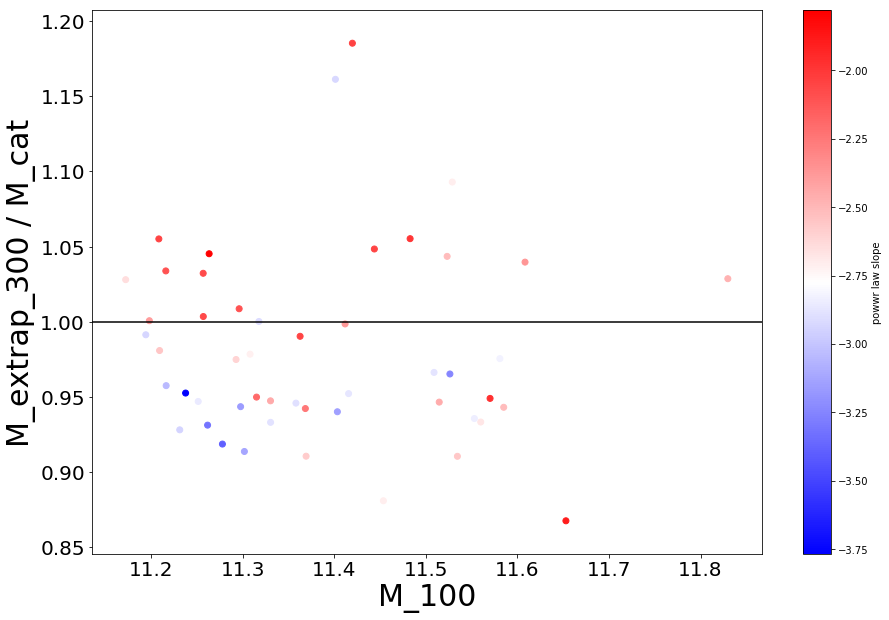

In [29]:
fig, ax = plt.subplots(1,1, figsize=(15, 10), sharex=True)
scatter = ax.scatter(similar_tng_masses['m_1d_100'], 10**(similar_tng_masses['extrapolated_m_300']-similar_tng_masses['m_cat']),
           alpha=1, c=power_law_slopes, cmap='bwr')
plt.colorbar(scatter, label= 'powwr law slope')

ax.tick_params(axis='both', which='major', labelsize=20)
ax.axhline(1.0, c='k')

plt.ylabel('M_extrap_300 / M_cat', fontsize=30)
plt.xlabel('M_100', fontsize=30)
plt.show()

In [30]:
extrapolated_masses_150 = np.array([extrapolated_1D_mass(iso, 150) for iso in similar_tng_isos])

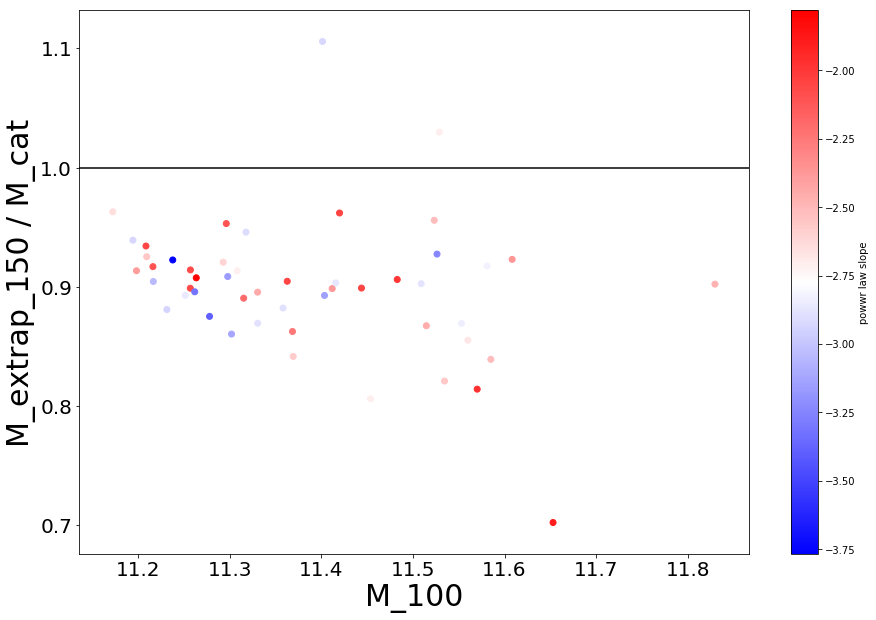

In [31]:
fig, ax = plt.subplots(1,1, figsize=(15, 10), sharex=True)
scatter = ax.scatter(similar_tng_masses['m_1d_100'], 10**(extrapolated_masses_150-similar_tng_masses['m_cat']),
           alpha=1, c=power_law_slopes, cmap='bwr')
plt.colorbar(scatter, label= 'powwr law slope')

ax.tick_params(axis='both', which='major', labelsize=20)
ax.axhline(1.0, c='k')

plt.ylabel('M_extrap_150 / M_cat', fontsize=30)
plt.xlabel('M_100', fontsize=30)
plt.show()

## power law intercept 

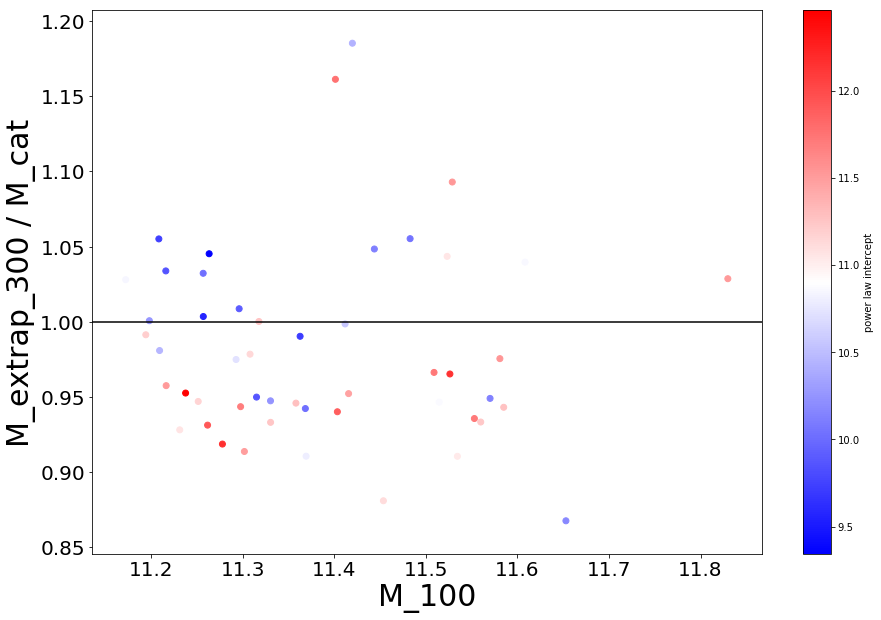

In [32]:
fig, ax = plt.subplots(1,1, figsize=(15, 10), sharex=True)
scatter = ax.scatter(similar_tng_masses['m_1d_100'], 10**(similar_tng_masses['extrapolated_m_300']-similar_tng_masses['m_cat']),
           alpha=1, c=power_law_intercepts, cmap='bwr')
plt.colorbar(scatter, label= 'power law intercept')

ax.tick_params(axis='both', which='major', labelsize=20)
ax.axhline(1.0, c='k')

plt.ylabel('M_extrap_300 / M_cat', fontsize=30)
plt.xlabel('M_100', fontsize=30)
plt.show()

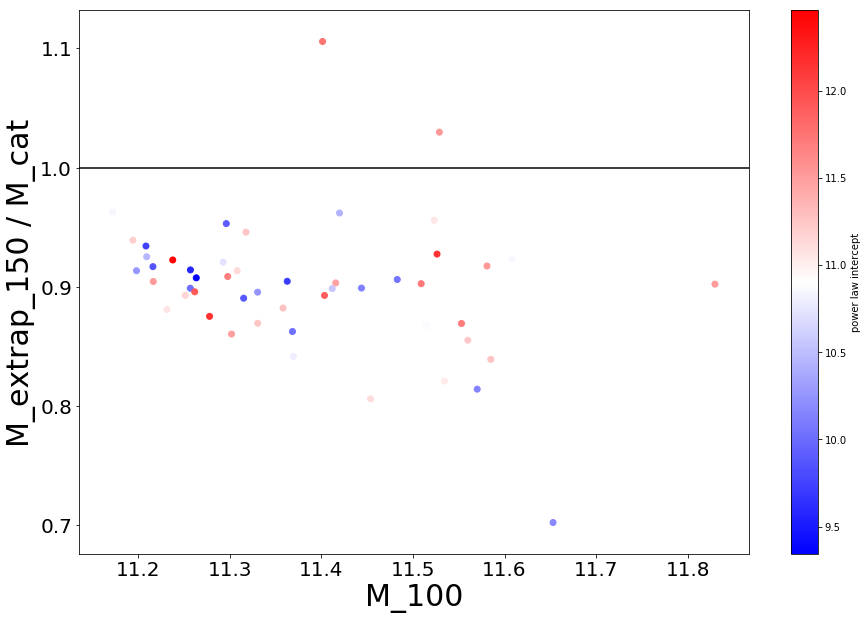

In [33]:
fig, ax = plt.subplots(1,1, figsize=(15, 10), sharex=True)
scatter = ax.scatter(similar_tng_masses['m_1d_100'], 10**(extrapolated_masses_150-similar_tng_masses['m_cat']),
           alpha=1, c=power_law_intercepts, cmap='bwr')
plt.colorbar(scatter, label= 'power law intercept')

ax.tick_params(axis='both', which='major', labelsize=20)
ax.axhline(1.0, c='k')

plt.ylabel('M_extrap_150 / M_cat', fontsize=30)
plt.xlabel('M_100', fontsize=30)
plt.show()

find extrapolation radius at which scatter in minimized

In [34]:
means = []
stds = []
rs = np.linspace(70,700,100)

for r in rs:
    extrapolated_masses = np.array([extrapolated_1D_mass(iso, r) for iso in similar_tng_isos])
    diffs = extrapolated_masses - similar_tng_masses['m_cat']
    mean = np.mean(diffs)
    scatter = np.std(diffs)
    
    means.append(mean)
    stds.append(scatter)

min scatter at :  184.54545454545453


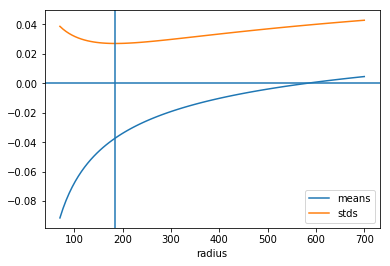

In [35]:
plt.plot(rs, means, label='means')
plt.plot(rs, stds, label='stds')
plt.axhline(0)
plt.axvline(rs[np.argmin(stds)])

plt.legend()
plt.xlabel('radius')

print 'min scatter at : ', rs[np.argmin(stds)]

##  M100/M*tot as a function of alpha

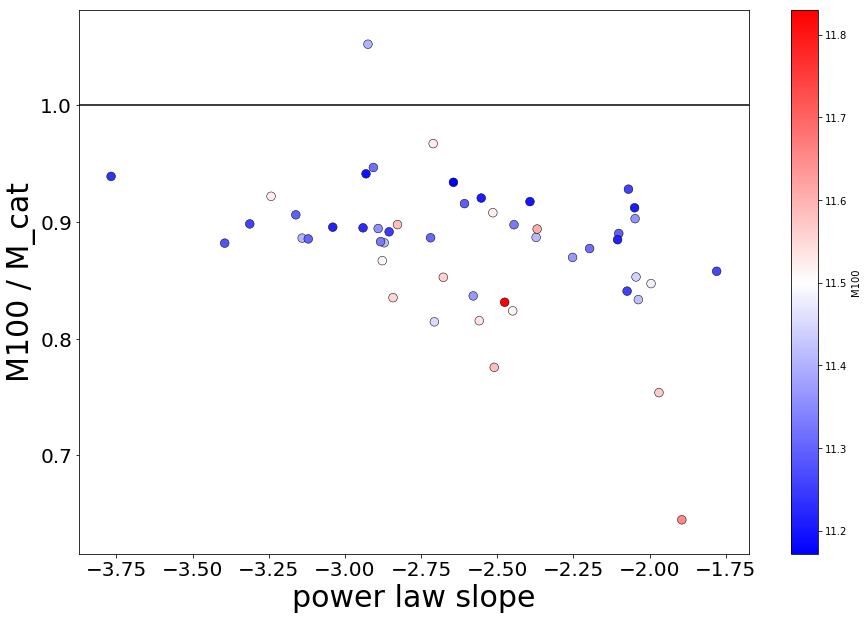

In [49]:
fig, ax = plt.subplots(1,1, figsize=(15, 10), sharex=True)
scatter = ax.scatter(power_law_slopes, 10**(similar_tng_masses['m_1d_100']-similar_tng_masses['m_cat']),
           alpha=1, c=similar_tng_masses['m_1d_100'], cmap='bwr', edgecolor='k', s=75, linewidth=0.5)
plt.colorbar(scatter, label= 'M100')

ax.tick_params(axis='both', which='major', labelsize=20)
ax.axhline(1.0, c='k')

plt.ylabel('M100 / M_cat', fontsize=30)
plt.xlabel('power law slope', fontsize=30)
plt.show()

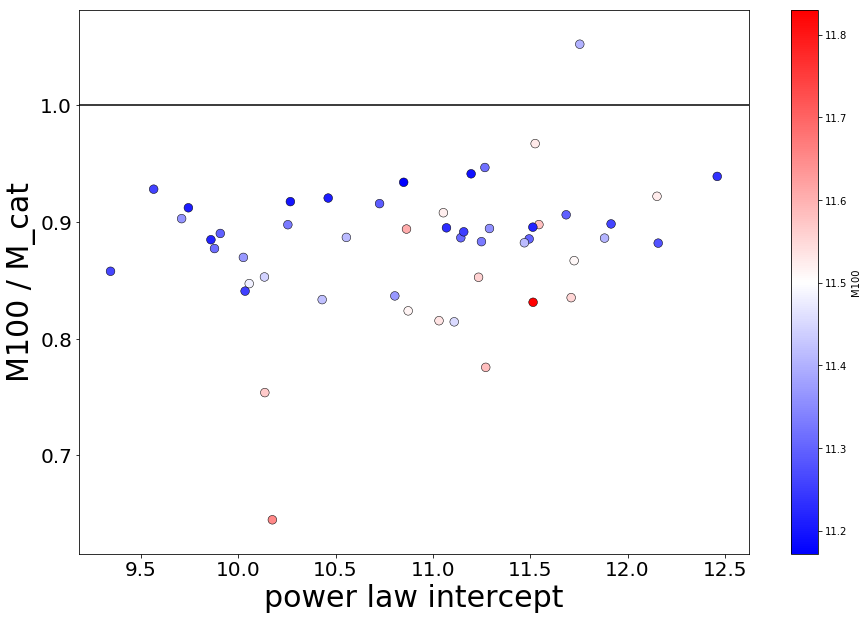

In [80]:
fig, ax = plt.subplots(1,1, figsize=(15, 10), sharex=True)
scatter = ax.scatter(power_law_intercepts, 10**(similar_tng_masses['m_1d_100']-similar_tng_masses['m_cat']),
           alpha=1, c=similar_tng_masses['m_1d_100'], cmap='bwr', edgecolor='k', s=75, linewidth=0.5)
plt.colorbar(scatter, label= 'M100')

ax.tick_params(axis='both', which='major', labelsize=20)
ax.axhline(1.0, c='k')

plt.ylabel('M100 / M_cat', fontsize=30)
plt.xlabel('power law intercept', fontsize=30)
plt.show()

In [75]:
import matplotlib as mpl

cmap = plt.cm.tab10  # define the colormap
# extract all colors from the .jet map
# cmaplist = [cmap(i) for i in range(3)]
cmaplist = ['#7fc97f','#beaed4','#fdc086']

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, 3)



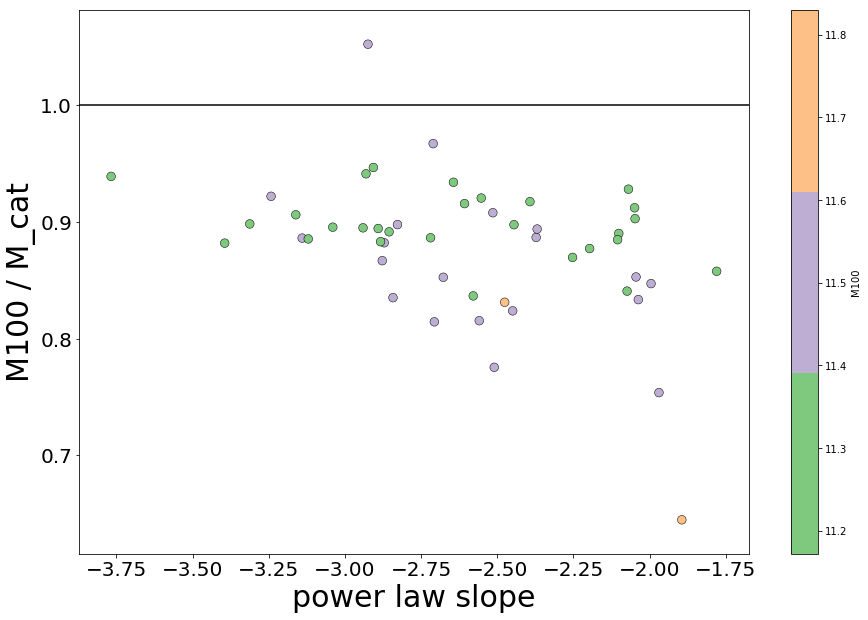

In [78]:
fig, ax = plt.subplots(1,1, figsize=(15, 10), sharex=True)
scatter = ax.scatter(power_law_slopes, 10**(similar_tng_masses['m_1d_100']-similar_tng_masses['m_cat']),
           alpha=1, c=similar_tng_masses['m_1d_100'], cmap=cmap, edgecolor='k', s=75, linewidth=0.5)
plt.colorbar(scatter, label= 'M100')

ax.tick_params(axis='both', which='major', labelsize=20)
ax.axhline(1.0, c='k')

plt.ylabel('M100 / M_cat', fontsize=30)
plt.xlabel('power law slope', fontsize=30)
plt.show()

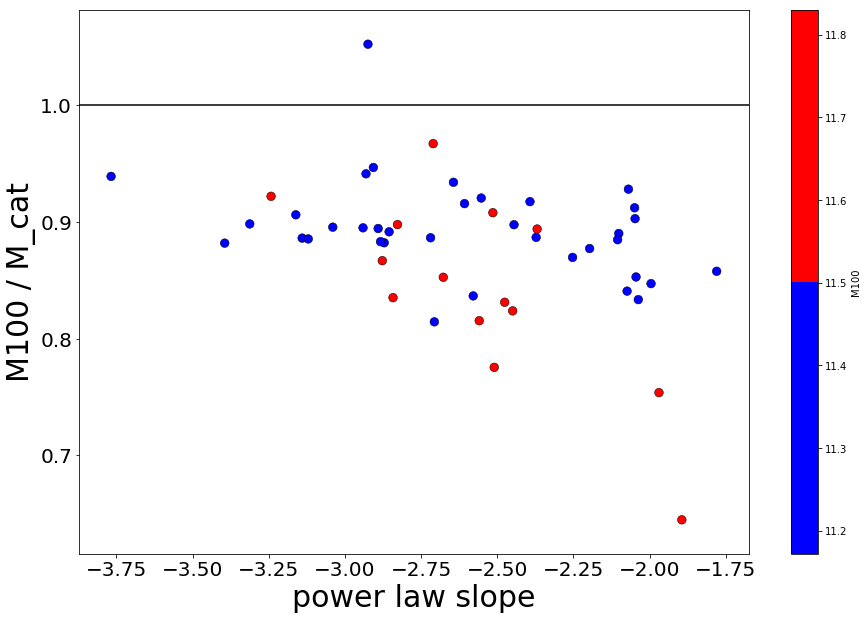

In [81]:
cmaplist = ['b','r']
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, 2)



fig, ax = plt.subplots(1,1, figsize=(15, 10), sharex=True)
scatter = ax.scatter(power_law_slopes, 10**(similar_tng_masses['m_1d_100']-similar_tng_masses['m_cat']),
           alpha=1, c=similar_tng_masses['m_1d_100'], cmap=cmap, edgecolor='k', s=75, linewidth=0.5)
plt.colorbar(scatter, label= 'M100')

ax.tick_params(axis='both', which='major', labelsize=20)
ax.axhline(1.0, c='k')

plt.ylabel('M100 / M_cat', fontsize=30)
plt.xlabel('power law slope', fontsize=30)
plt.show()

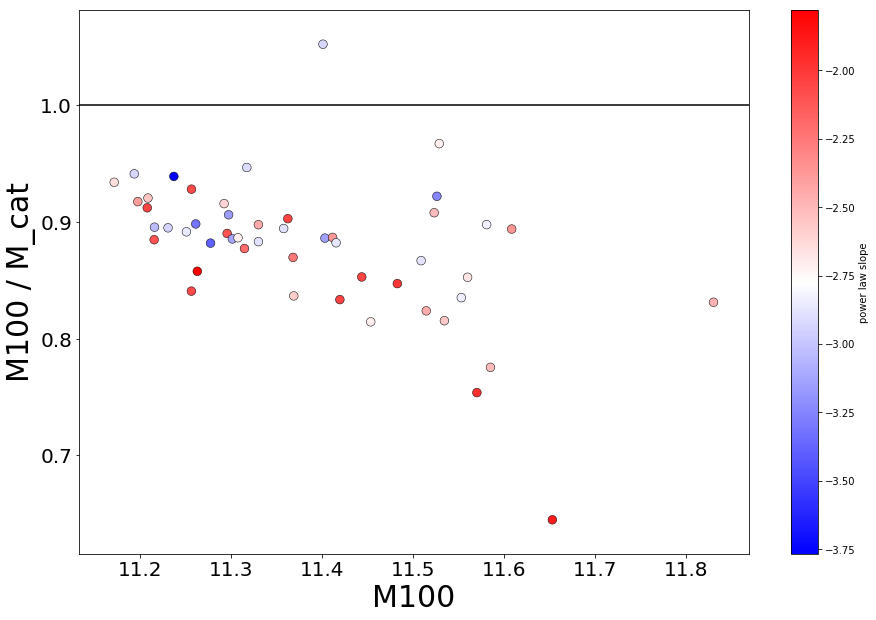

In [17]:
fig, ax = plt.subplots(1,1, figsize=(15, 10), sharex=True)
scatter = ax.scatter(similar_tng_masses['m_1d_100'], 10**(similar_tng_masses['m_1d_100']-similar_tng_masses['m_cat']),
           alpha=1, c=power_law_slopes, cmap='bwr', edgecolor='k', s=75, linewidth=0.5)
plt.colorbar(scatter, label='power law slope')

ax.tick_params(axis='both', which='major', labelsize=20)
ax.axhline(1.0, c='k')

plt.ylabel('M100 / M_cat', fontsize=30)
plt.xlabel('M100', fontsize=30)
plt.show()

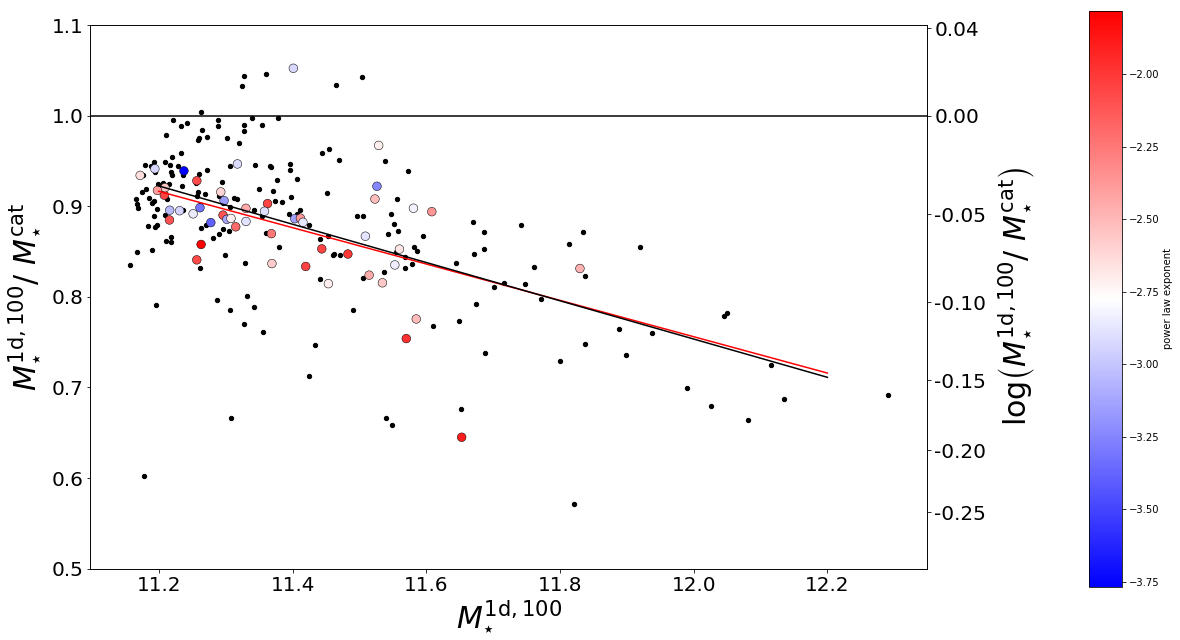

In [72]:
fig, ax = plt.subplots(1,1, figsize=(15, 10), sharex=True)


# automatically update ylim of ax2 when ylim of ax1 changes.
# ax.callbacks.connect("ylim_changed", convert_ax_2_to_log)

ax.scatter(tng_masses['m_1d_100'], 10**(tng_masses['m_1d_100']-tng_masses['m_cat']),
           alpha=1, c='k', s=75, marker='.')
scatter = ax.scatter(similar_tng_masses['m_1d_100'], 10**(similar_tng_masses['m_1d_100']-similar_tng_masses['m_cat']),
           alpha=1, c=power_law_slopes, cmap='bwr', edgecolor='k', s=75, linewidth=0.5)

#add lines
p_HSC = np.poly1d(np.polyfit(similar_tng_masses['m_1d_100'], 10**(similar_tng_masses['m_1d_100']-similar_tng_masses['m_cat']), 1))
p_all = np.poly1d(np.polyfit(tng_masses['m_1d_100'], 10**(tng_masses['m_1d_100']-tng_masses['m_cat']), 1))
plt.plot([11.2,12.2],p_HSC([11.2,12.2]), c='r')
plt.plot([11.2,12.2],p_all([11.2,12.2]),c='k')

cbaxes = fig.add_axes([1.05, 0.1, 0.03, 0.8])
cb = plt.colorbar(scatter, label='power law exponent', cax = cbaxes )

ax.tick_params(axis='both', which='major', labelsize=20)
ax.axhline(1.0, c='k')

ax.set_ylim([0.5,1.1])
#add twin x axis in kpc
ax2 = ax.twinx()
ax2.set_ylim([0.5,1.1])
ax2.figure.canvas.draw()
ax2.yaxis.set_ticks([10**0.04, 10**0, 10**-0.05, 10**-0.10, 10**-0.15, 10**-0.2, 10**-0.25])
ax2.yaxis.set_ticklabels([0.04,'0.00',-0.05,'-0.10',-0.15,'-0.20',-0.25])
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_ylabel(r'$\log\left(M_{\star}^{\mathrm{1d, 100}} /\ M_{\star}^{\mathrm{cat}}\right)$', fontsize=30, labelpad = 10)
    
ax.set_ylabel(r'$M_{\star}^{\mathrm{1d, 100}} /\ M_{\star}^{\mathrm{cat}}$', fontsize=30, labelpad = 10)
ax.set_xlabel(r'$M_{\star}^{\mathrm{1d, 100}}$', fontsize=30)
plt.show()

In [37]:
power_law_slopes_all = [fit_power_law_to_iso(iso, 50, 100)[0] for iso in tng_isos]

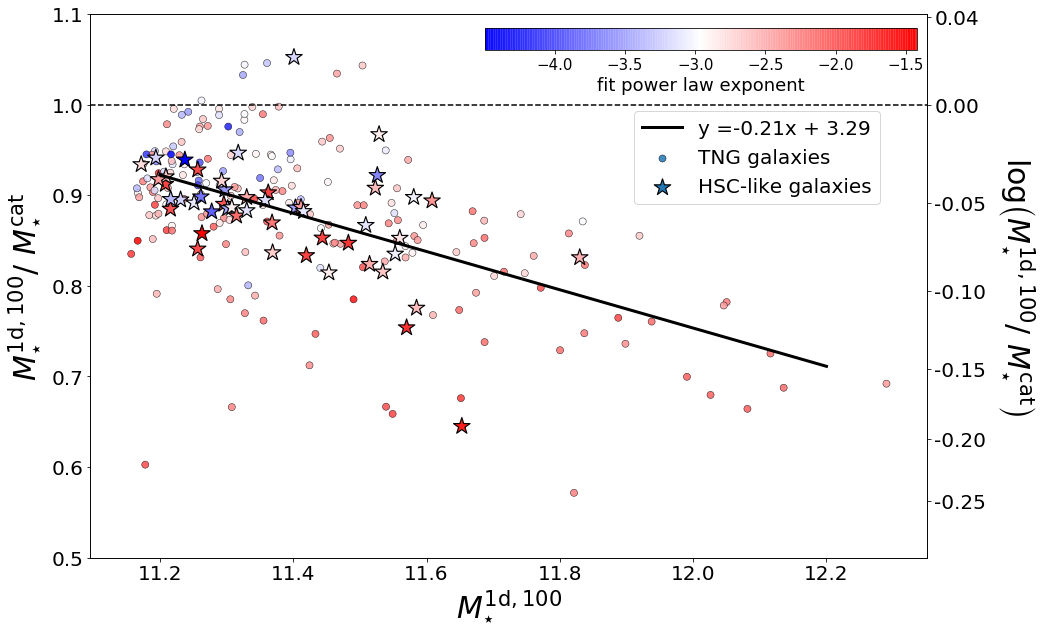

In [56]:
fig, ax = plt.subplots(1,1, figsize=(15, 10), sharex=True)


scatter_all = ax.scatter(tng_masses['m_1d_100'], 10**(tng_masses['m_1d_100']-tng_masses['m_cat']),
           alpha=0.85, c=power_law_slopes_all, cmap='bwr', edgecolor='k', s=50, linewidth=0.5,
                        label='TNG galaxies')
ax.scatter(similar_tng_masses['m_1d_100'], 10**(similar_tng_masses['m_1d_100']-similar_tng_masses['m_cat']),
           alpha=1, c=power_law_slopes, cmap='bwr', edgecolor='k', s=300, linewidth=1.15, marker='*',
                    label='HSC-like galaxies')

ax.axhline(1.0, c='k', linestyle='--')
#add lines
params= np.polyfit(tng_masses['m_1d_100'], 10**(tng_masses['m_1d_100']-tng_masses['m_cat']), 1)
p_all = np.poly1d(params)
plt.plot([11.2,12.2],p_all([11.2,12.2]),c='k', linewidth=3, label='y ={0}x + {1}'.format(round(params[0],2),
                                                                                         round(params[1],2)))
plt.legend( loc=(0.65,0.65), fontsize=20)
#colorbar
cax = fig.add_axes([0.49, 0.83, 0.4, 0.03])
cb = plt.colorbar(scatter_all, orientation='horizontal', cax = cax)
cb.ax.tick_params(labelsize=15) 
cb.set_label('fit power law exponent', size=18)

ax.set_ylim([0.5,1.1])
ax.tick_params(axis='both', which='major', labelsize=20)

#add twin yaxis
ax2 = ax.twinx()
ax2.set_ylim([0.5,1.1])
ax2.figure.canvas.draw()
ax2.yaxis.set_ticks([10**0.04, 10**0, 10**-0.05, 10**-0.10, 10**-0.15, 10**-0.2, 10**-0.25])
ax2.yaxis.set_ticklabels([0.04,'0.00',-0.05,'-0.10',-0.15,'-0.20',-0.25])
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_ylabel(r'$\log\left(M_{\star}^{\mathrm{1d, 100}} /\ M_{\star}^{\mathrm{cat}}\right)$', fontsize=30,
               labelpad = 50, rotation=270)
    
ax.set_ylabel(r'$M_{\star}^{\mathrm{1d, 100}} /\ M_{\star}^{\mathrm{cat}}$', fontsize=30, labelpad = 10)
ax.set_xlabel(r'$M_{\star}^{\mathrm{1d, 100}}$', fontsize=30)

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/mass_correction_all.pdf',
        dpi=100, format='pdf', bbox_inches='tight')

plt.show()

## check if related to ellipticity 

In [21]:
mean_ellipticities = [tng_isos[i]['ell'][1] for i in range(len(tng_isos))]

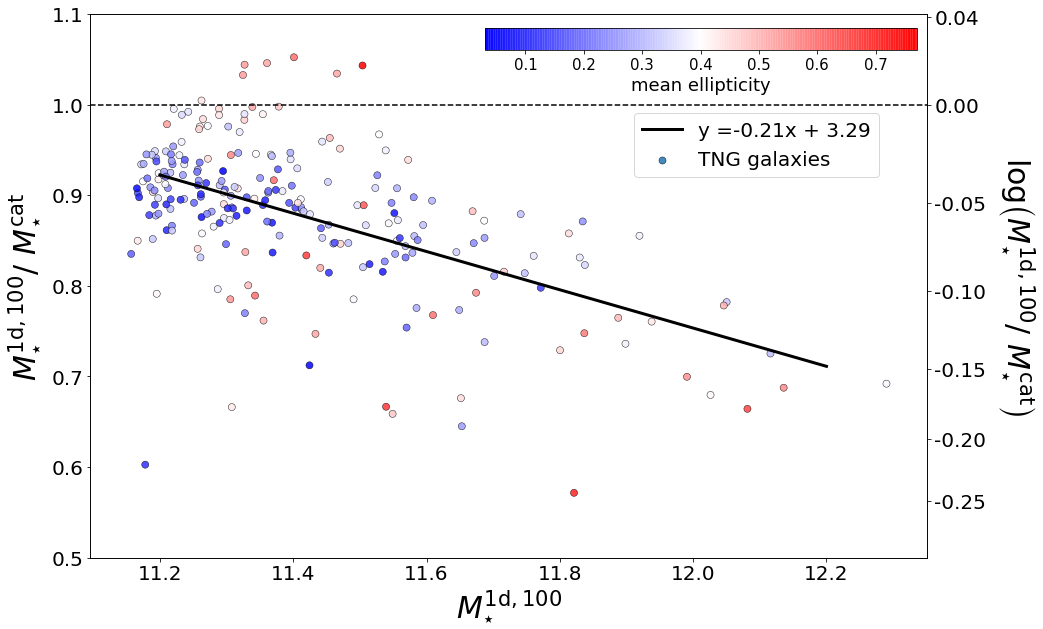

In [35]:
fig, ax = plt.subplots(1,1, figsize=(15, 10), sharex=True)


scatter_all = ax.scatter(tng_masses['m_1d_100'], 10**(tng_masses['m_1d_100']-tng_masses['m_cat']),
           alpha=0.85, c=mean_ellipticities, cmap='bwr', edgecolor='k', s=50, linewidth=0.5,
                        label='TNG galaxies')
ax.axhline(1.0, c='k', linestyle='--')
#add lines
params= np.polyfit(tng_masses['m_1d_100'], 10**(tng_masses['m_1d_100']-tng_masses['m_cat']), 1)
p_all = np.poly1d(params)
plt.plot([11.2,12.2],p_all([11.2,12.2]),c='k', linewidth=3, label='y ={0}x + {1}'.format(round(params[0],2),
                                                                                         round(params[1],2)))
plt.legend( loc=(0.65,0.7), fontsize=20)
#colorbar
cax = fig.add_axes([0.49, 0.83, 0.4, 0.03])
cb = plt.colorbar(scatter_all, orientation='horizontal', cax = cax)
cb.ax.tick_params(labelsize=15) 
cb.set_label('mean ellipticity', size=18)

ax.set_ylim([0.5,1.1])
ax.tick_params(axis='both', which='major', labelsize=20)

#add twin yaxis
ax2 = ax.twinx()
ax2.set_ylim([0.5,1.1])
ax2.figure.canvas.draw()
ax2.yaxis.set_ticks([10**0.04, 10**0, 10**-0.05, 10**-0.10, 10**-0.15, 10**-0.2, 10**-0.25])
ax2.yaxis.set_ticklabels([0.04,'0.00',-0.05,'-0.10',-0.15,'-0.20',-0.25])
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_ylabel(r'$\log\left(M_{\star}^{\mathrm{1d, 100}} /\ M_{\star}^{\mathrm{cat}}\right)$', fontsize=30,
               labelpad = 50, rotation=270)
    
ax.set_ylabel(r'$M_{\star}^{\mathrm{1d, 100}} /\ M_{\star}^{\mathrm{cat}}$', fontsize=30, labelpad = 10)
ax.set_xlabel(r'$M_{\star}^{\mathrm{1d, 100}}$', fontsize=30)

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/mass_correction_all.pdf',
#         dpi=100, format='pdf', bbox_inches='tight')

plt.show()

## check if related to M10 

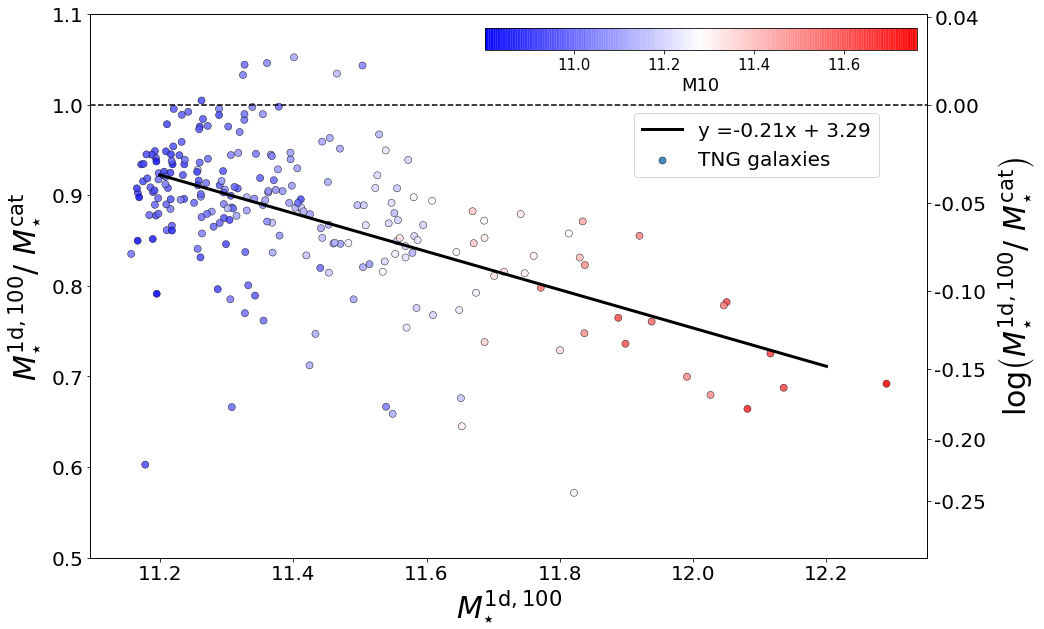

In [27]:
fig, ax = plt.subplots(1,1, figsize=(15, 10), sharex=True)


scatter_all = ax.scatter(tng_masses['m_1d_100'], 10**(tng_masses['m_1d_100']-tng_masses['m_cat']),
           alpha=0.85, c=tng_masses['m_1d_10'], cmap='bwr', edgecolor='k', s=50, linewidth=0.5,
                        label='TNG galaxies')
ax.axhline(1.0, c='k', linestyle='--')
#add lines
params= np.polyfit(tng_masses['m_1d_100'], 10**(tng_masses['m_1d_100']-tng_masses['m_cat']), 1)
p_all = np.poly1d(params)
plt.plot([11.2,12.2],p_all([11.2,12.2]),c='k', linewidth=3, label='y ={0}x + {1}'.format(round(params[0],2),
                                                                                         round(params[1],2)))
plt.legend( loc=(0.65,0.7), fontsize=20)
#colorbar
cax = fig.add_axes([0.49, 0.83, 0.4, 0.03])
cb = plt.colorbar(scatter_all, orientation='horizontal', cax = cax)
cb.ax.tick_params(labelsize=15) 
cb.set_label('M10', size=18)

ax.set_ylim([0.5,1.1])
ax.tick_params(axis='both', which='major', labelsize=20)

#add twin yaxis
ax2 = ax.twinx()
ax2.set_ylim([0.5,1.1])
ax2.figure.canvas.draw()
ax2.yaxis.set_ticks([10**0.04, 10**0, 10**-0.05, 10**-0.10, 10**-0.15, 10**-0.2, 10**-0.25])
ax2.yaxis.set_ticklabels([0.04,'0.00',-0.05,'-0.10',-0.15,'-0.20',-0.25])
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_ylabel(r'$\log\left(M_{\star}^{\mathrm{1d, 100}} /\ M_{\star}^{\mathrm{cat}}\right)$', fontsize=30, labelpad = 10)
    
ax.set_ylabel(r'$M_{\star}^{\mathrm{1d, 100}} /\ M_{\star}^{\mathrm{cat}}$', fontsize=30, labelpad = 10)
ax.set_xlabel(r'$M_{\star}^{\mathrm{1d, 100}}$', fontsize=30)

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/mass_correction_all.pdf',
#         dpi=100, format='pdf', bbox_inches='tight')

plt.show()

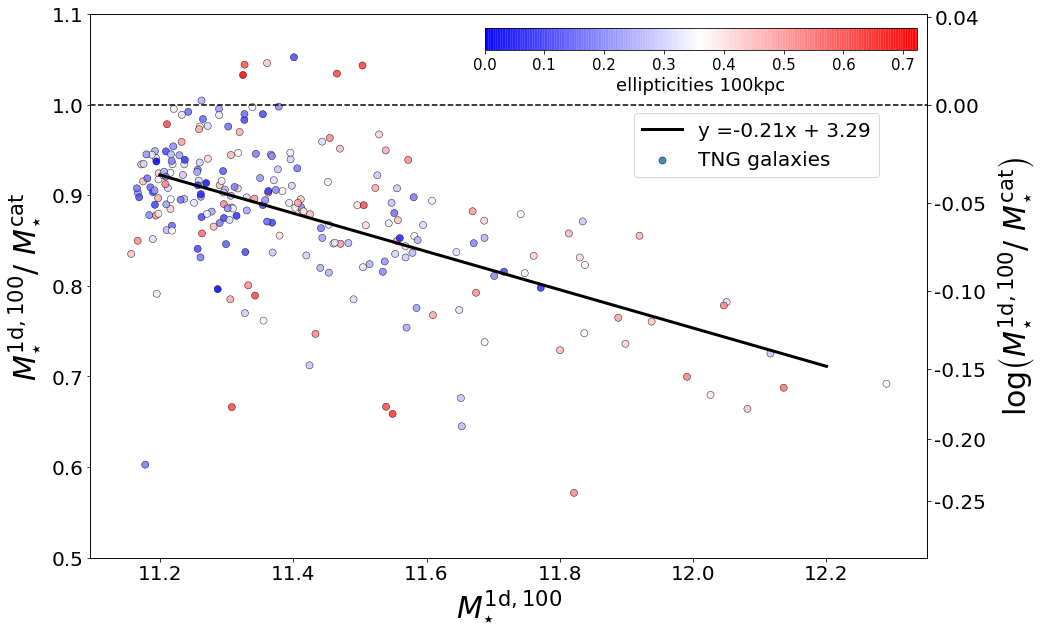

In [36]:
fig, ax = plt.subplots(1,1, figsize=(15, 10), sharex=True)


scatter_all = ax.scatter(tng_masses['m_1d_100'], 10**(tng_masses['m_1d_100']-tng_masses['m_cat']),
           alpha=0.85, c=ellipticities_100kpc, cmap='bwr', edgecolor='k', s=50, linewidth=0.5,
                        label='TNG galaxies')
ax.axhline(1.0, c='k', linestyle='--')
#add lines
params= np.polyfit(tng_masses['m_1d_100'], 10**(tng_masses['m_1d_100']-tng_masses['m_cat']), 1)
p_all = np.poly1d(params)
plt.plot([11.2,12.2],p_all([11.2,12.2]),c='k', linewidth=3, label='y ={0}x + {1}'.format(round(params[0],2),
                                                                                         round(params[1],2)))
plt.legend( loc=(0.65,0.7), fontsize=20)
#colorbar
cax = fig.add_axes([0.49, 0.83, 0.4, 0.03])
cb = plt.colorbar(scatter_all, orientation='horizontal', cax = cax)
cb.ax.tick_params(labelsize=15) 
cb.set_label('ellipticities 100kpc', size=18)

ax.set_ylim([0.5,1.1])
ax.tick_params(axis='both', which='major', labelsize=20)

#add twin yaxis
ax2 = ax.twinx()
ax2.set_ylim([0.5,1.1])
ax2.figure.canvas.draw()
ax2.yaxis.set_ticks([10**0.04, 10**0, 10**-0.05, 10**-0.10, 10**-0.15, 10**-0.2, 10**-0.25])
ax2.yaxis.set_ticklabels([0.04,'0.00',-0.05,'-0.10',-0.15,'-0.20',-0.25])
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_ylabel(r'$\log\left(M_{\star}^{\mathrm{1d, 100}} /\ M_{\star}^{\mathrm{cat}}\right)$', fontsize=30, labelpad = 10)
    
ax.set_ylabel(r'$M_{\star}^{\mathrm{1d, 100}} /\ M_{\star}^{\mathrm{cat}}$', fontsize=30, labelpad = 10)
ax.set_xlabel(r'$M_{\star}^{\mathrm{1d, 100}}$', fontsize=30)

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/mass_correction_all.pdf',
#         dpi=100, format='pdf', bbox_inches='tight')

plt.show()

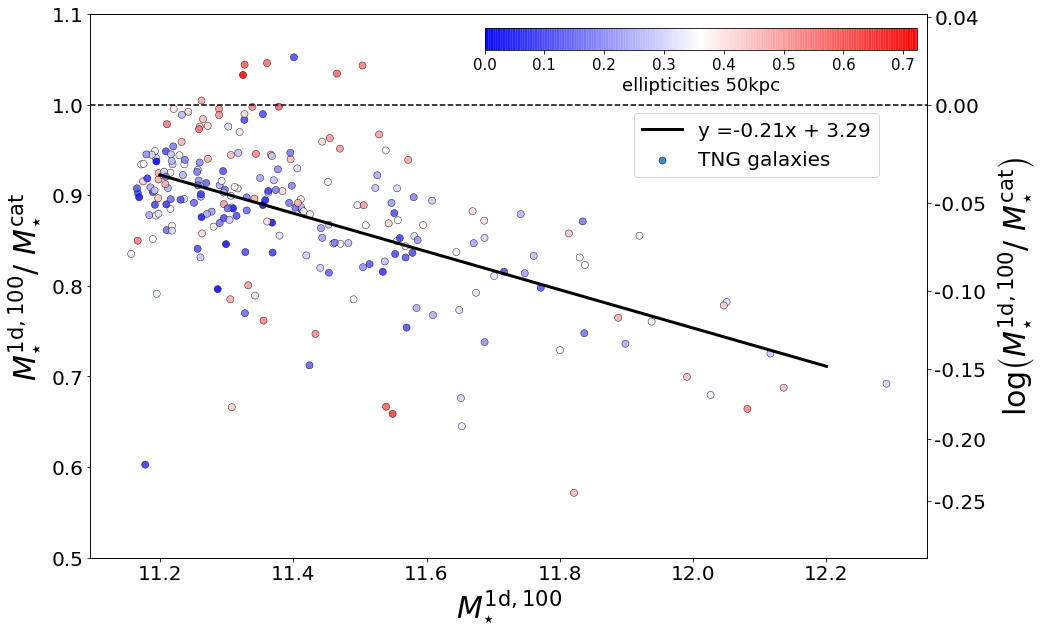

In [48]:
fig, ax = plt.subplots(1,1, figsize=(15, 10), sharex=True)


scatter_all = ax.scatter(tng_masses['m_1d_100'], 10**(tng_masses['m_1d_100']-tng_masses['m_cat']),
           alpha=0.85, c=ellipticities_50kpc, cmap='bwr', edgecolor='k', s=50, linewidth=0.5,
                        label='TNG galaxies')
ax.axhline(1.0, c='k', linestyle='--')
#add lines
params= np.polyfit(tng_masses['m_1d_100'], 10**(tng_masses['m_1d_100']-tng_masses['m_cat']), 1)
p_all = np.poly1d(params)
plt.plot([11.2,12.2],p_all([11.2,12.2]),c='k', linewidth=3, label='y ={0}x + {1}'.format(round(params[0],2),
                                                                                         round(params[1],2)))
plt.legend( loc=(0.65,0.7), fontsize=20)
#colorbar
cax = fig.add_axes([0.49, 0.83, 0.4, 0.03])
cb = plt.colorbar(scatter_all, orientation='horizontal', cax = cax)
cb.ax.tick_params(labelsize=15) 
cb.set_label('ellipticities 50kpc', size=18)

ax.set_ylim([0.5,1.1])
ax.tick_params(axis='both', which='major', labelsize=20)

#add twin yaxis
ax2 = ax.twinx()
ax2.set_ylim([0.5,1.1])
ax2.figure.canvas.draw()
ax2.yaxis.set_ticks([10**0.04, 10**0, 10**-0.05, 10**-0.10, 10**-0.15, 10**-0.2, 10**-0.25])
ax2.yaxis.set_ticklabels([0.04,'0.00',-0.05,'-0.10',-0.15,'-0.20',-0.25])
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_ylabel(r'$\log\left(M_{\star}^{\mathrm{1d, 100}} /\ M_{\star}^{\mathrm{cat}}\right)$', fontsize=30, labelpad = 10)
    
ax.set_ylabel(r'$M_{\star}^{\mathrm{1d, 100}} /\ M_{\star}^{\mathrm{cat}}$', fontsize=30, labelpad = 10)
ax.set_xlabel(r'$M_{\star}^{\mathrm{1d, 100}}$', fontsize=30)

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/mass_correction_all.pdf',
#         dpi=100, format='pdf', bbox_inches='tight')

plt.show()

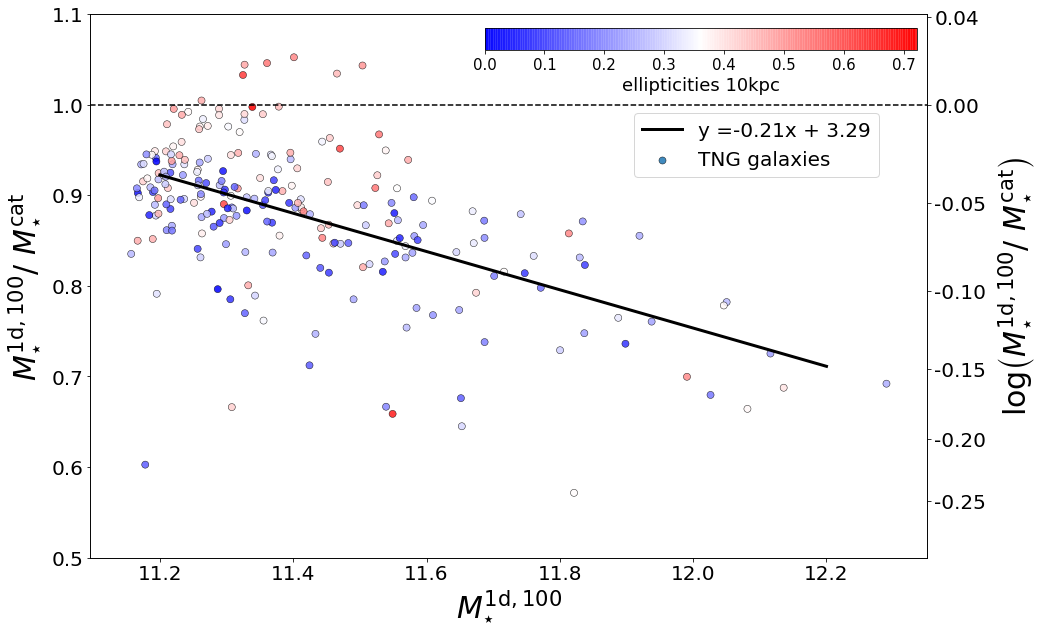

In [44]:
fig, ax = plt.subplots(1,1, figsize=(15, 10), sharex=True)


scatter_all = ax.scatter(tng_masses['m_1d_100'], 10**(tng_masses['m_1d_100']-tng_masses['m_cat']),
           alpha=0.85, c=ellipticities_10kpc, cmap='bwr', edgecolor='k', s=50, linewidth=0.5,
                        label='TNG galaxies')
ax.axhline(1.0, c='k', linestyle='--')
#add lines
params= np.polyfit(tng_masses['m_1d_100'], 10**(tng_masses['m_1d_100']-tng_masses['m_cat']), 1)
p_all = np.poly1d(params)
plt.plot([11.2,12.2],p_all([11.2,12.2]),c='k', linewidth=3, label='y ={0}x + {1}'.format(round(params[0],2),
                                                                                         round(params[1],2)))
plt.legend( loc=(0.65,0.7), fontsize=20)
#colorbar
cax = fig.add_axes([0.49, 0.83, 0.4, 0.03])
cb = plt.colorbar(scatter_all, orientation='horizontal', cax = cax)
cb.ax.tick_params(labelsize=15) 
cb.set_label('ellipticities 10kpc', size=18)

ax.set_ylim([0.5,1.1])
ax.tick_params(axis='both', which='major', labelsize=20)

#add twin yaxis
ax2 = ax.twinx()
ax2.set_ylim([0.5,1.1])
ax2.figure.canvas.draw()
ax2.yaxis.set_ticks([10**0.04, 10**0, 10**-0.05, 10**-0.10, 10**-0.15, 10**-0.2, 10**-0.25])
ax2.yaxis.set_ticklabels([0.04,'0.00',-0.05,'-0.10',-0.15,'-0.20',-0.25])
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_ylabel(r'$\log\left(M_{\star}^{\mathrm{1d, 100}} /\ M_{\star}^{\mathrm{cat}}\right)$', fontsize=30, labelpad = 10)
    
ax.set_ylabel(r'$M_{\star}^{\mathrm{1d, 100}} /\ M_{\star}^{\mathrm{cat}}$', fontsize=30, labelpad = 10)
ax.set_xlabel(r'$M_{\star}^{\mathrm{1d, 100}}$', fontsize=30)

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/mass_correction_all.pdf',
#         dpi=100, format='pdf', bbox_inches='tight')

plt.show()

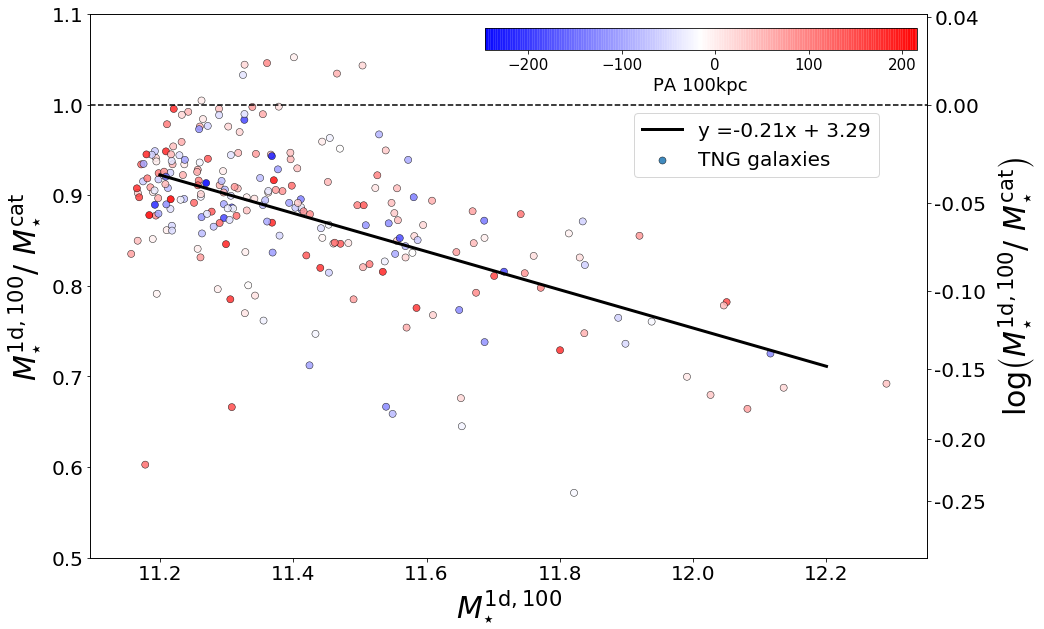

In [37]:
fig, ax = plt.subplots(1,1, figsize=(15, 10), sharex=True)


scatter_all = ax.scatter(tng_masses['m_1d_100'], 10**(tng_masses['m_1d_100']-tng_masses['m_cat']),
           alpha=0.85, c=pa_100kpc, cmap='bwr', edgecolor='k', s=50, linewidth=0.5,
                        label='TNG galaxies')
ax.axhline(1.0, c='k', linestyle='--')
#add lines
params= np.polyfit(tng_masses['m_1d_100'], 10**(tng_masses['m_1d_100']-tng_masses['m_cat']), 1)
p_all = np.poly1d(params)
plt.plot([11.2,12.2],p_all([11.2,12.2]),c='k', linewidth=3, label='y ={0}x + {1}'.format(round(params[0],2),
                                                                                         round(params[1],2)))
plt.legend( loc=(0.65,0.7), fontsize=20)
#colorbar
cax = fig.add_axes([0.49, 0.83, 0.4, 0.03])
cb = plt.colorbar(scatter_all, orientation='horizontal', cax = cax)
cb.ax.tick_params(labelsize=15) 
cb.set_label('PA 100kpc', size=18)

ax.set_ylim([0.5,1.1])
ax.tick_params(axis='both', which='major', labelsize=20)

#add twin yaxis
ax2 = ax.twinx()
ax2.set_ylim([0.5,1.1])
ax2.figure.canvas.draw()
ax2.yaxis.set_ticks([10**0.04, 10**0, 10**-0.05, 10**-0.10, 10**-0.15, 10**-0.2, 10**-0.25])
ax2.yaxis.set_ticklabels([0.04,'0.00',-0.05,'-0.10',-0.15,'-0.20',-0.25])
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_ylabel(r'$\log\left(M_{\star}^{\mathrm{1d, 100}} /\ M_{\star}^{\mathrm{cat}}\right)$', fontsize=30, labelpad = 10)
    
ax.set_ylabel(r'$M_{\star}^{\mathrm{1d, 100}} /\ M_{\star}^{\mathrm{cat}}$', fontsize=30, labelpad = 10)
ax.set_xlabel(r'$M_{\star}^{\mathrm{1d, 100}}$', fontsize=30)

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/mass_correction_all.pdf',
#         dpi=100, format='pdf', bbox_inches='tight')

plt.show()

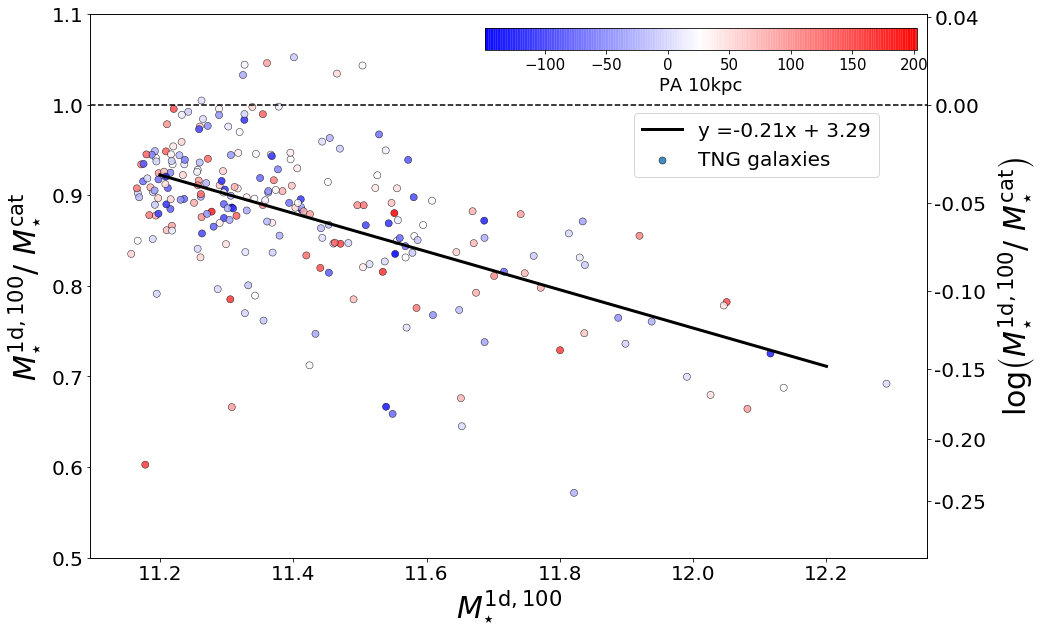

In [47]:
fig, ax = plt.subplots(1,1, figsize=(15, 10), sharex=True)


scatter_all = ax.scatter(tng_masses['m_1d_100'], 10**(tng_masses['m_1d_100']-tng_masses['m_cat']),
           alpha=0.85, c=pa_10kpc, cmap='bwr', edgecolor='k', s=50, linewidth=0.5,
                        label='TNG galaxies')
ax.axhline(1.0, c='k', linestyle='--')
#add lines
params= np.polyfit(tng_masses['m_1d_100'], 10**(tng_masses['m_1d_100']-tng_masses['m_cat']), 1)
p_all = np.poly1d(params)
plt.plot([11.2,12.2],p_all([11.2,12.2]),c='k', linewidth=3, label='y ={0}x + {1}'.format(round(params[0],2),
                                                                                         round(params[1],2)))
plt.legend( loc=(0.65,0.7), fontsize=20)
#colorbar
cax = fig.add_axes([0.49, 0.83, 0.4, 0.03])
cb = plt.colorbar(scatter_all, orientation='horizontal', cax = cax)
cb.ax.tick_params(labelsize=15) 
cb.set_label('PA 10kpc', size=18)

ax.set_ylim([0.5,1.1])
ax.tick_params(axis='both', which='major', labelsize=20)

#add twin yaxis
ax2 = ax.twinx()
ax2.set_ylim([0.5,1.1])
ax2.figure.canvas.draw()
ax2.yaxis.set_ticks([10**0.04, 10**0, 10**-0.05, 10**-0.10, 10**-0.15, 10**-0.2, 10**-0.25])
ax2.yaxis.set_ticklabels([0.04,'0.00',-0.05,'-0.10',-0.15,'-0.20',-0.25])
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_ylabel(r'$\log\left(M_{\star}^{\mathrm{1d, 100}} /\ M_{\star}^{\mathrm{cat}}\right)$', fontsize=30, labelpad = 10)
    
ax.set_ylabel(r'$M_{\star}^{\mathrm{1d, 100}} /\ M_{\star}^{\mathrm{cat}}$', fontsize=30, labelpad = 10)
ax.set_xlabel(r'$M_{\star}^{\mathrm{1d, 100}}$', fontsize=30)

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/mass_correction_all.pdf',
#         dpi=100, format='pdf', bbox_inches='tight')

plt.show()

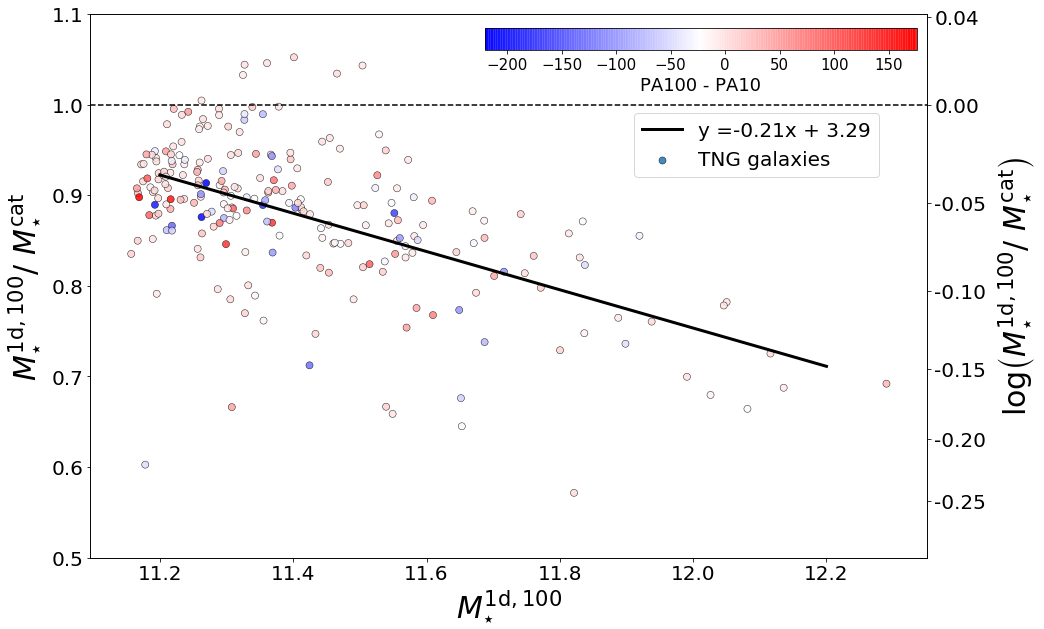

In [42]:
fig, ax = plt.subplots(1,1, figsize=(15, 10), sharex=True)


scatter_all = ax.scatter(tng_masses['m_1d_100'], 10**(tng_masses['m_1d_100']-tng_masses['m_cat']),
           alpha=0.85, c=pa_diff, cmap='bwr', edgecolor='k', s=50, linewidth=0.5,
                        label='TNG galaxies')
ax.axhline(1.0, c='k', linestyle='--')
#add lines
params= np.polyfit(tng_masses['m_1d_100'], 10**(tng_masses['m_1d_100']-tng_masses['m_cat']), 1)
p_all = np.poly1d(params)
plt.plot([11.2,12.2],p_all([11.2,12.2]),c='k', linewidth=3, label='y ={0}x + {1}'.format(round(params[0],2),
                                                                                         round(params[1],2)))
plt.legend( loc=(0.65,0.7), fontsize=20)
#colorbar
cax = fig.add_axes([0.49, 0.83, 0.4, 0.03])
cb = plt.colorbar(scatter_all, orientation='horizontal', cax = cax)
cb.ax.tick_params(labelsize=15) 
cb.set_label('PA100 - PA10', size=18)

ax.set_ylim([0.5,1.1])
ax.tick_params(axis='both', which='major', labelsize=20)

#add twin yaxis
ax2 = ax.twinx()
ax2.set_ylim([0.5,1.1])
ax2.figure.canvas.draw()
ax2.yaxis.set_ticks([10**0.04, 10**0, 10**-0.05, 10**-0.10, 10**-0.15, 10**-0.2, 10**-0.25])
ax2.yaxis.set_ticklabels([0.04,'0.00',-0.05,'-0.10',-0.15,'-0.20',-0.25])
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_ylabel(r'$\log\left(M_{\star}^{\mathrm{1d, 100}} /\ M_{\star}^{\mathrm{cat}}\right)$', fontsize=30, labelpad = 10)
    
ax.set_ylabel(r'$M_{\star}^{\mathrm{1d, 100}} /\ M_{\star}^{\mathrm{cat}}$', fontsize=30, labelpad = 10)
ax.set_xlabel(r'$M_{\star}^{\mathrm{1d, 100}}$', fontsize=30)

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/mass_correction_all.pdf',
#         dpi=100, format='pdf', bbox_inches='tight')

plt.show()

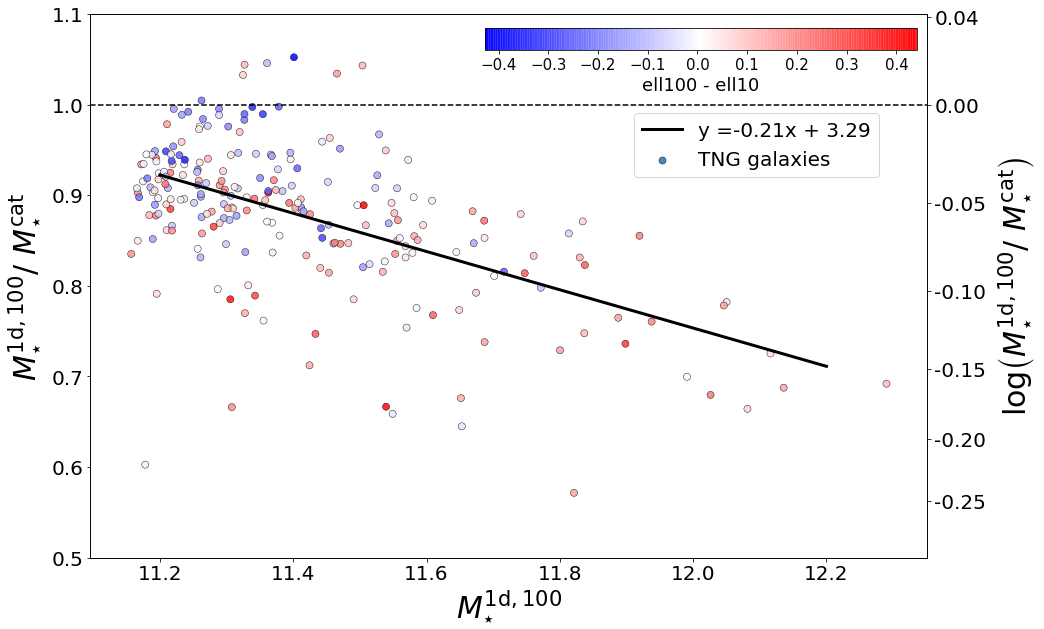

In [46]:
fig, ax = plt.subplots(1,1, figsize=(15, 10), sharex=True)


scatter_all = ax.scatter(tng_masses['m_1d_100'], 10**(tng_masses['m_1d_100']-tng_masses['m_cat']),
           alpha=0.85, c=ellipticity_diff, cmap='bwr', edgecolor='k', s=50, linewidth=0.5,
                        label='TNG galaxies')
ax.axhline(1.0, c='k', linestyle='--')
#add lines
params= np.polyfit(tng_masses['m_1d_100'], 10**(tng_masses['m_1d_100']-tng_masses['m_cat']), 1)
p_all = np.poly1d(params)
plt.plot([11.2,12.2],p_all([11.2,12.2]),c='k', linewidth=3, label='y ={0}x + {1}'.format(round(params[0],2),
                                                                                         round(params[1],2)))
plt.legend( loc=(0.65,0.7), fontsize=20)
#colorbar
cax = fig.add_axes([0.49, 0.83, 0.4, 0.03])
cb = plt.colorbar(scatter_all, orientation='horizontal', cax = cax)
cb.ax.tick_params(labelsize=15) 
cb.set_label('ell100 - ell10', size=18)

ax.set_ylim([0.5,1.1])
ax.tick_params(axis='both', which='major', labelsize=20)

#add twin yaxis
ax2 = ax.twinx()
ax2.set_ylim([0.5,1.1])
ax2.figure.canvas.draw()
ax2.yaxis.set_ticks([10**0.04, 10**0, 10**-0.05, 10**-0.10, 10**-0.15, 10**-0.2, 10**-0.25])
ax2.yaxis.set_ticklabels([0.04,'0.00',-0.05,'-0.10',-0.15,'-0.20',-0.25])
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_ylabel(r'$\log\left(M_{\star}^{\mathrm{1d, 100}} /\ M_{\star}^{\mathrm{cat}}\right)$', fontsize=30, labelpad = 10)
    
ax.set_ylabel(r'$M_{\star}^{\mathrm{1d, 100}} /\ M_{\star}^{\mathrm{cat}}$', fontsize=30, labelpad = 10)
ax.set_xlabel(r'$M_{\star}^{\mathrm{1d, 100}}$', fontsize=30)

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/mass_correction_all.pdf',
#         dpi=100, format='pdf', bbox_inches='tight')

plt.show()